<a href="https://colab.research.google.com/github/SimplyDifficult/ML-for-Wireless/blob/main/20.EI_P%3D20_20_dim_user_case_BOGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
P_max = 20 #in dBm

In [2]:
var = 20
number_of_cells = 4

In [3]:
!sudo add-apt-repository ppa:octave/stable
!sudo apt update
!sudo apt install octave

 The latest version of GNU Octave built for all supported Ubuntu releases. GNU Octave is normally distributed with Ubuntu, this PPA is for you if you have a need to use a newer version of Octave than what you can already get from your installed version of Ubuntu.

Simply follow the instructions below to add this PPA to your system and install the octave package. If it's not that easy or you encounter any errors, contact the team and let us know.

Much credit goes to the Debian Octave Group who maintain the official Debian packages that this work is derived from. Without their efforts to bring Octave packaging to such a high level of quality in Debian and Debian derivatives, this PPA would not be here.
 More info: https://launchpad.net/~octave/+archive/ubuntu/stable
Press [ENTER] to continue or Ctrl-c to cancel adding it.

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:

In [4]:
!wget https://www.dropbox.com/s/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
!wget https://www.dropbox.com/s/d1ytzzfpxsrpbcv/main_bitchanged.m -O /content/main.m
!wget https://www.dropbox.com/s/v3y2xe56qodthnm/function_SE.m
!wget https://www.dropbox.com/s/5p0j4qdqist7ibm/main_individual_transmit_case_for_Test_phase_bitchanged.m -O /content/main_individual_transmit_case_for_Test_phase.m

--2021-10-29 19:48:35--  https://www.dropbox.com/s/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m [following]
--2021-10-29 19:48:35--  https://www.dropbox.com/s/raw/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc044eac2f9f38a8fc549b53ab9c.dl.dropboxusercontent.com/cd/0/inline/BY_DcWIlTM-oyUO0r4pWo7l8AQP_Osl2ifJAWICvJIG9HVGksHn1UEKUh3Xt_OShPXVwBq-wbdNKS7Leno1bk1zGnuZRLdpdryFVke-v3_0E0xmJf2h9Cmm0QG6O2wQa5FLVd1CBIh9hsEYrPUk07Lyw/file# [following]
--2021-10-29 19:48:35--  https://uc044eac2f9f38a8fc549b53ab9c.dl.dr

In [5]:
!wget https://www.dropbox.com/s/utf73kdk09gjvsu/RR.mat
!wget https://www.dropbox.com/s/52gyqiq137mo2bb/SE.mat

--2021-10-29 19:48:38--  https://www.dropbox.com/s/utf73kdk09gjvsu/RR.mat
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/utf73kdk09gjvsu/RR.mat [following]
--2021-10-29 19:48:39--  https://www.dropbox.com/s/raw/utf73kdk09gjvsu/RR.mat
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc15878c019a6853369ac6fbc08e.dl.dropboxusercontent.com/cd/0/inline/BY99K6fbq5kYLaXNOOgVAdCkFjpnkTDiHLVY00C9BEHdam_jhKXnm6r87JShVkhe9o2zTZbNMxW-xvpJhIoZl7HVioQQEQHZEgs225bYcegmonrCs787Sy7EBXKeaSdRRjetkiZWu7KMn1d53QkCiwpp/file# [following]
--2021-10-29 19:48:39--  https://uc15878c019a6853369ac6fbc08e.dl.dropboxusercontent.com/cd/0/inline/BY99K6fbq5kYLaXNOOgVAdCkFjpnkTDiHLVY00C9BEHdam_jhKXnm6r87JShVkhe9o2zTZbNMxW-xvpJhIoZl7HVioQQEQHZEgs225bYcegm

In [6]:
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
from scipy.optimize import minimize
import numpy as np
from scipy.io import loadmat, savemat
import numpy as np
from google.colab import files
import cv2
from scipy.optimize import dual_annealing

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
#### Objective function
import random
def objective(tr_array):
  tr_in_mW = np.power(10,tr_array/10.0)
  savemat("transmit.mat", {"transmit":(tr_in_mW)})
  !octave -W main.m
  SE = loadmat('SE.mat')
  return np.sum(SE["SE"])

In [9]:
#surrogate or approximation for the objective function
def surrogate(model, X):
	#catch any warning generated when making a prediction
	with catch_warnings():
		#ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

In [10]:
def EIacquisition(Xsamples, X, model):
  Xsamples = Xsamples[np.newaxis,:]
  yhat, _ = surrogate(model, X)
  best = max(yhat)
  mu, std = surrogate(model, Xsamples)
  mu = mu[:, 0]
  sigma = 0
  probs = (mu - best - sigma) * norm.cdf((mu - best - sigma)/(std+1e-10)) + std * norm.pdf((mu - best - sigma)/(std+1e-10))
  return -probs[0]

In [11]:
#optimize the acquisition function
def opt_acquisition(X, y, model):
  #Do it 5 times
  r_min, r_max = -31.0, P_max  
  bounds = []
  for ti in range(var):
    bounds = bounds + [[r_min, r_max]]
  min_result = 9999999999999.0
  min_answer = 0
  
  for i in range(1):
    result = dual_annealing(EIacquisition, bounds, args=(X,model))
    if(result.fun<min_result):
      min_result = result.fun
      min_answer = result['x']    
  return min_answer

In [12]:
import random
def objective_FPA(tr_array):
  tr_in_mW = np.power(10,tr_array/10.0)
  savemat("transmit.mat", {"transmit":(tr_in_mW)})
  !octave -W /content/main_individual_transmit_case_for_Test_phase.m
  SE = loadmat('SE.mat')
  return np.sum(SE["SE"])

In [13]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [14]:
X = np.load("/content/drive/MyDrive/trainingx_BOGP_EI_P=20.npy")
y = np.load("/content/drive/MyDrive/trainingy_BOGP_EI_P=20.npy")
y_FPA = np.load("/content/drive/MyDrive/grad_trainingyFPA_BOGP_EI_P=20.npy")

x_next is [-1.07338463 -1.18484826 -1.44685294  0.62413811 -0.12668036 -1.66852427
  0.62718405 -0.08556042 -1.54693986  1.0792736   0.93894028 -0.62501164
 -1.079354    1.06579766  0.15585833  1.44958327  1.28860078 -1.38632686
  0.47107735  0.19515516]
f()=0.000000, actual=26.436
0


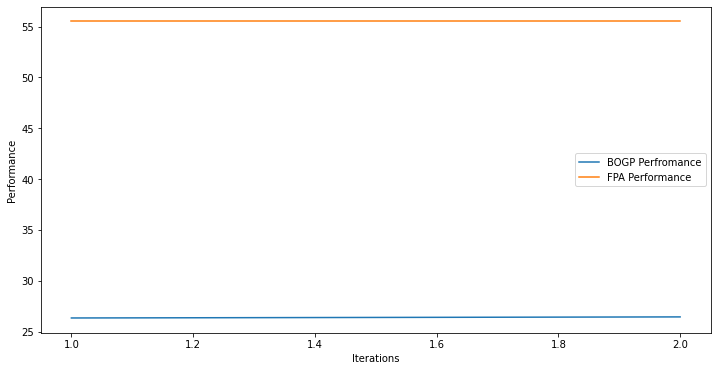

x_next is [-31.         -30.99977133 -30.99961967 -30.99999133 -31.
 -31.         -31.         -31.         -30.99921379 -30.99973756
 -31.         -30.99998189 -31.         -31.         -31.
 -31.         -31.         -31.         -30.99996639 -30.99966939]
f()=26.383634, actual=0.094
1


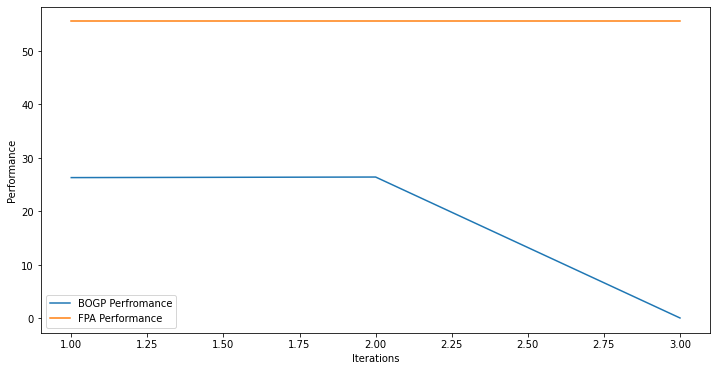

x_next is [14.97628507 13.91192769 11.41020204 20.         20.          9.29447409
 20.         20.         10.45441003 20.         20.         19.25698333
 14.91919366 20.         20.         20.         20.         11.98851072
 20.         20.        ]
f()=25.555053, actual=49.511
2


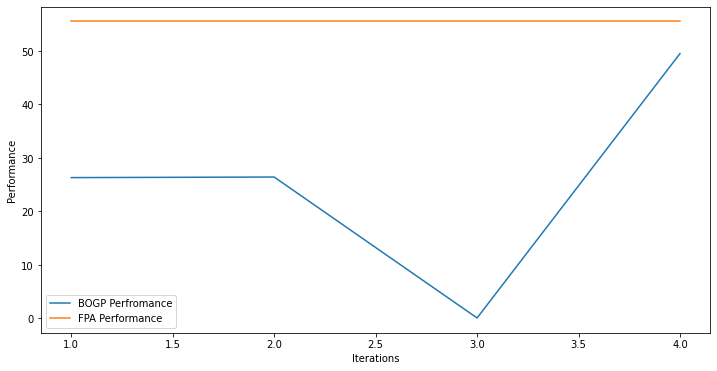

x_next is [ 20.  20. -31.  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.  20.
  20.  20.  20.  20.  20.  20.]
f()=48.353246, actual=55.240
3


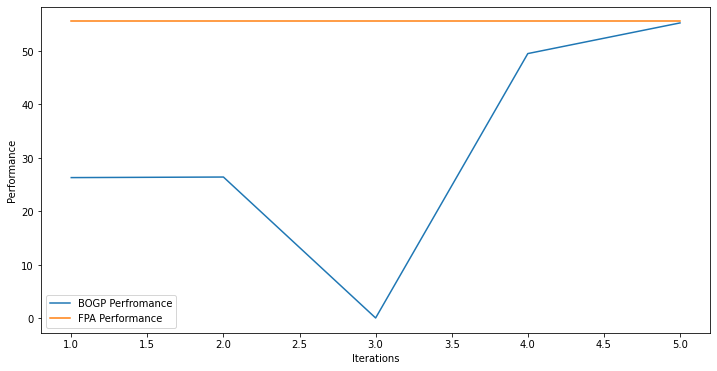

x_next is [ 20.  20. -31.  20.  20.  20.  20.  20.  20.  20.  20.  20. -31.  20.
  20.  20.  20.  20.  20.  20.]
f()=51.097794, actual=52.428
4


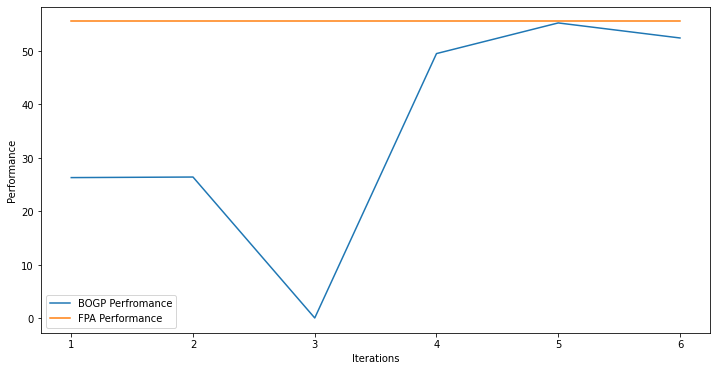

x_next is [ 20.  20. -31.  20.  20.  20.  20.  20.  20. -31.  20.  20.  20.  20.
  20.  20.  20.  20.  20.  20.]
f()=50.971537, actual=54.937
5


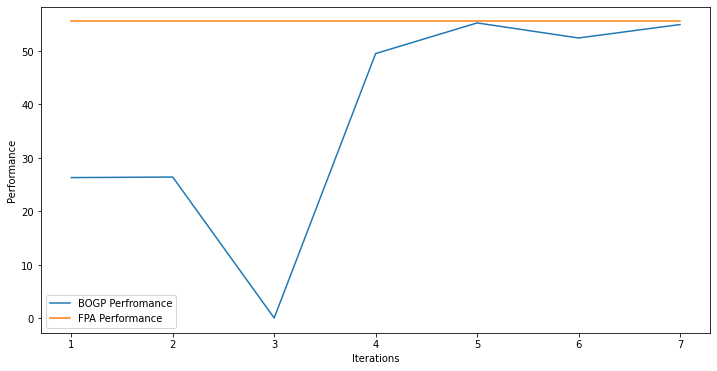

x_next is [ 20.          20.         -31.          20.          20.
  20.          20.          20.         -31.          12.28070065
  20.          20.          20.          20.          20.
  20.          20.          20.          20.          20.        ]
f()=51.661225, actual=57.757
6


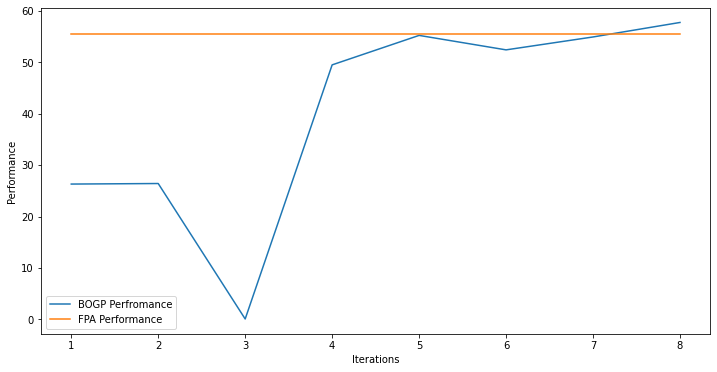

x_next is [ 20.          20.         -31.          20.          20.
  20.          20.          20.         -31.          20.
  20.          20.          20.          20.          20.
  20.         -31.          19.99998851  20.          20.        ]
f()=53.536591, actual=52.507
7


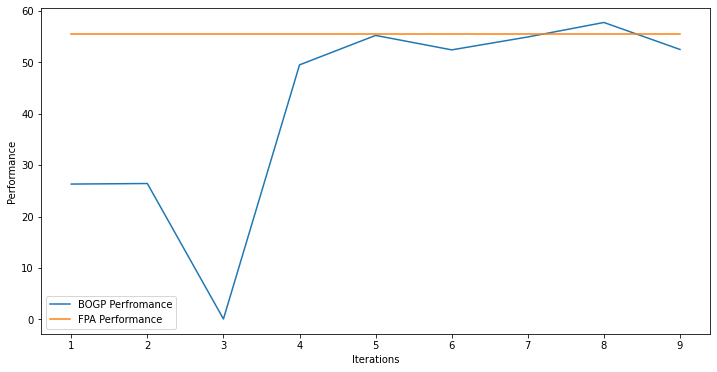

x_next is [ 20.  20. -31.  20.  20.  20.  20.  20. -31.  20.  20.  20.  20. -31.
  20.  20.  20.  20.  20.  20.]
f()=53.577216, actual=54.115
8


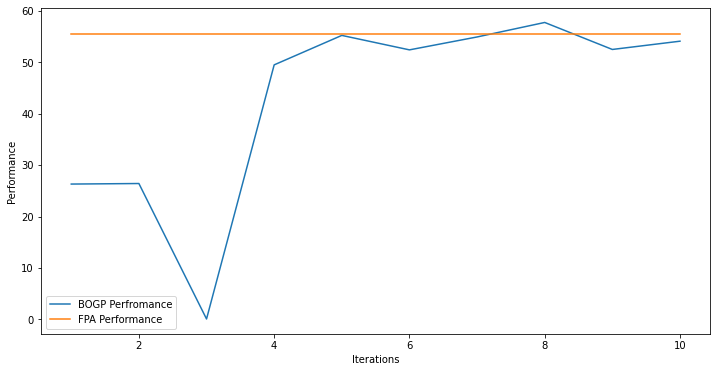

x_next is [ 20.          20.         -31.          20.          20.
  20.          20.          20.         -31.          19.99999982
  20.          20.          20.          20.          20.
  20.          20.          20.         -30.99997536  20.        ]
f()=53.338463, actual=51.113
9


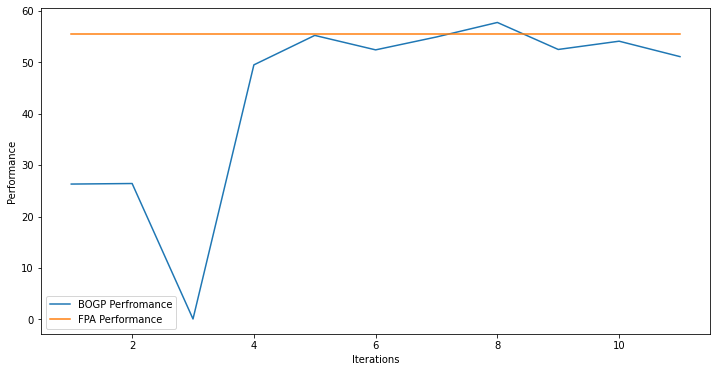

x_next is [ 20.          20.         -31.          20.          20.
  20.          20.         -30.99999998 -30.99999999  19.99996327
  20.          20.          20.          20.          20.
  20.          20.          20.          20.          20.        ]
f()=53.177020, actual=53.589
10


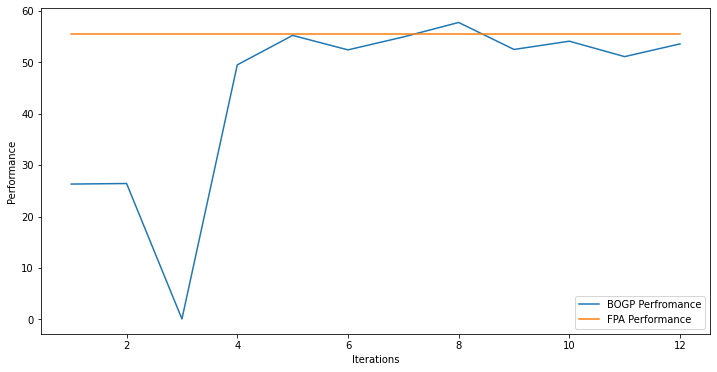

x_next is [ 20.  20. -31.  20.  20.  20.  20.  20. -31.  20.  20.  20.  20.  20.
  20. -31.  20.  20.  20.  20.]
f()=53.930266, actual=51.619
11


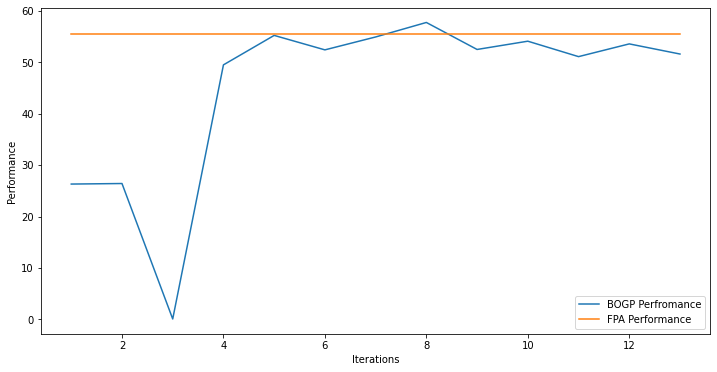

x_next is [ 20.          20.         -30.99999996  20.          20.
  20.         -30.99999999  20.         -30.99987983  20.
  20.          20.          20.          20.          20.
  20.          20.          20.          20.          20.        ]
f()=53.698068, actual=53.647
12


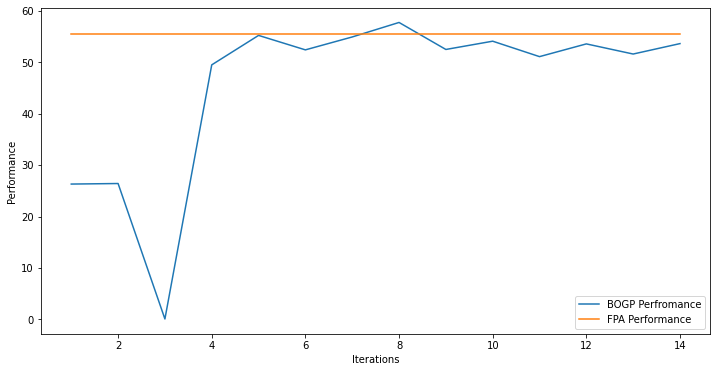

x_next is [ 20.          20.         -30.99999991  20.         -30.99999993
  20.          20.          20.         -30.9998588   19.99999967
  20.          20.          20.          20.          20.
  20.          20.          20.          20.          20.        ]
f()=53.228410, actual=51.546
13


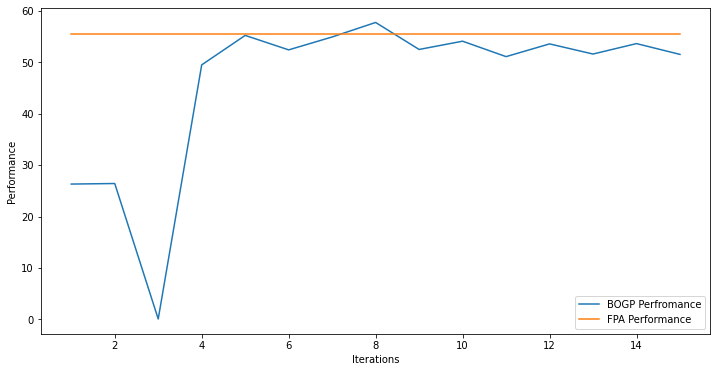

x_next is [ 20.  20. -31.  20.  20.  20.  20.  20. -31.  20.  20.  20.  20.  20.
 -31.  20.  20.  20.  20.  20.]
f()=53.487803, actual=54.151
14


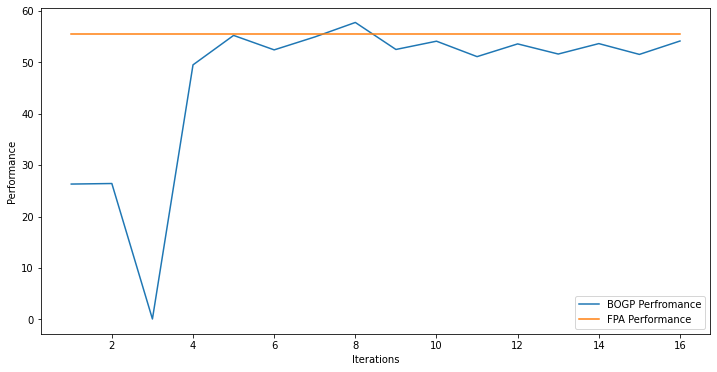

x_next is [ 20.          20.         -30.99999999  20.          20.
  20.          20.          20.         -30.99998011  19.99978204
 -30.99976198  20.          20.          20.          20.
  20.          20.          20.          20.          20.        ]
f()=54.010641, actual=54.914
15


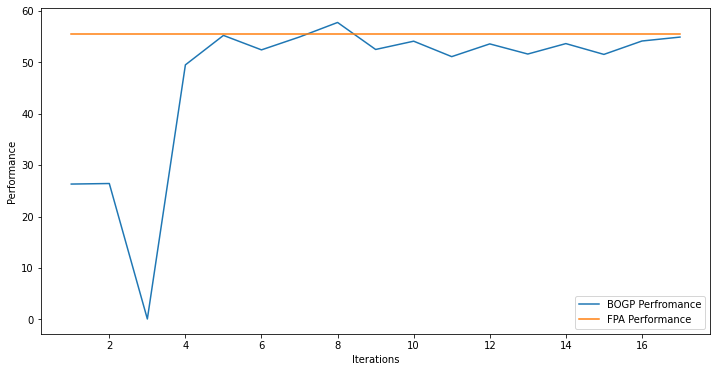

x_next is [ 20.          20.         -30.99991075 -30.99951724  20.
  20.          20.          20.         -30.99999998  20.
  19.9998129   20.          20.          20.          20.
  20.          20.          20.          20.          20.        ]
f()=53.795055, actual=53.266
16


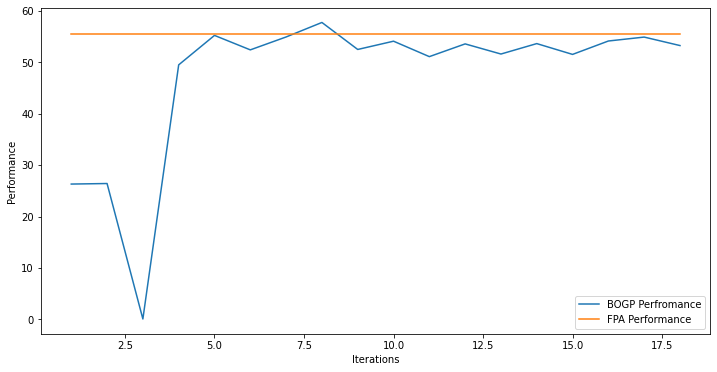

x_next is [ 20.          20.         -31.          20.          20.
  20.          20.          20.         -30.99993184  20.
  20.          20.          20.          20.          20.
  20.          20.          20.          20.         -31.        ]
f()=53.562534, actual=52.079
17


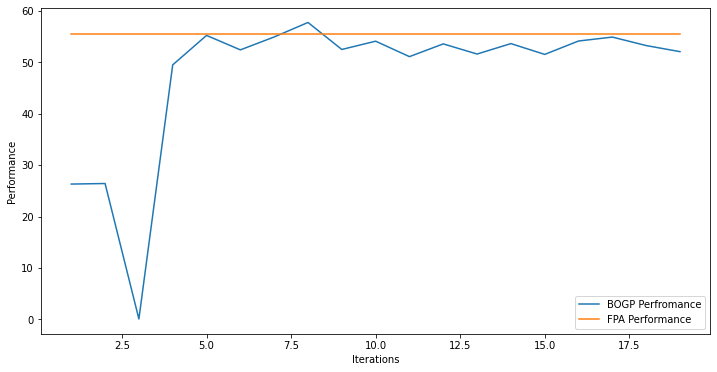

x_next is [ 20.         -30.99998956 -30.99999998  20.          20.
  20.          20.          20.         -30.99999998  -2.77152414
  20.          20.          19.99999999  20.          20.
  20.          20.          20.          20.          20.        ]
f()=52.995843, actual=54.326
18


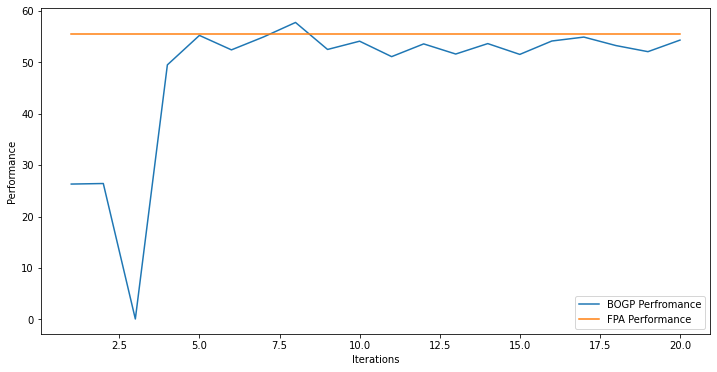

x_next is [ 19.99994583  19.99999999 -30.99999997  20.          20.
  19.99999999  20.          20.         -30.99973016   9.44174327
  19.99999999 -30.99977485  19.99999998  19.99988373  20.
  20.          20.          19.99999999  20.          20.        ]
f()=53.024132, actual=57.109
19


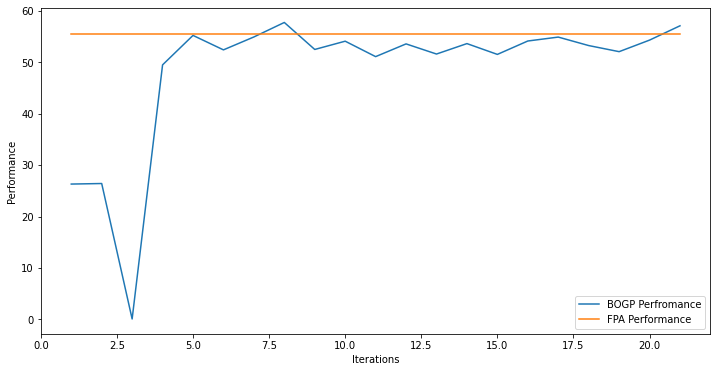

x_next is [ 20.          20.         -31.          20.          20.
  20.          19.99999999  20.         -31.         -31.
  19.99999998  20.          20.          20.          19.99999999
  20.          20.          20.          20.          19.99999999]
f()=57.395046, actual=54.638
20


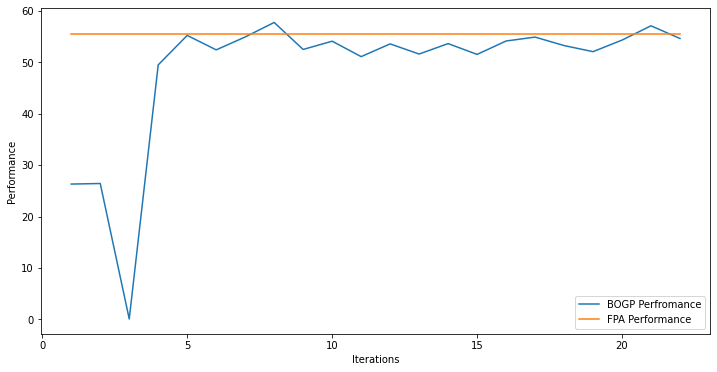

x_next is [ 20.          20.         -31.          20.          20.
  20.          20.          20.         -30.99996047  20.
  20.           4.72982027  20.          20.          20.
  20.          20.          20.          20.          20.        ]
f()=58.073488, actual=54.378
21


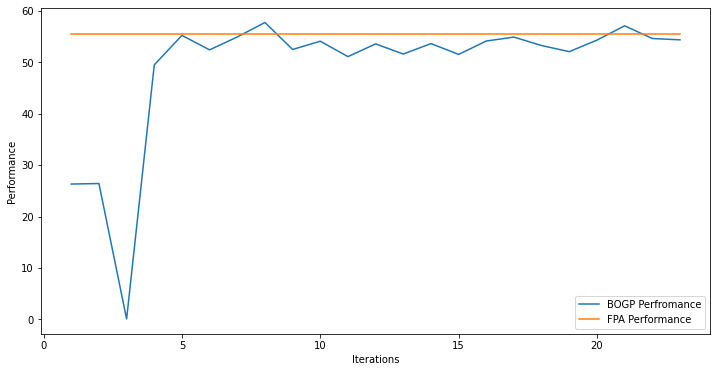

x_next is [ 20.  20. -31.  20.  20.  20.  20.  20. -31.  20.  20.  20.  20.  20.
  20.  20.  20.  20.  20.  20.]
f()=56.792823, actual=54.935
22


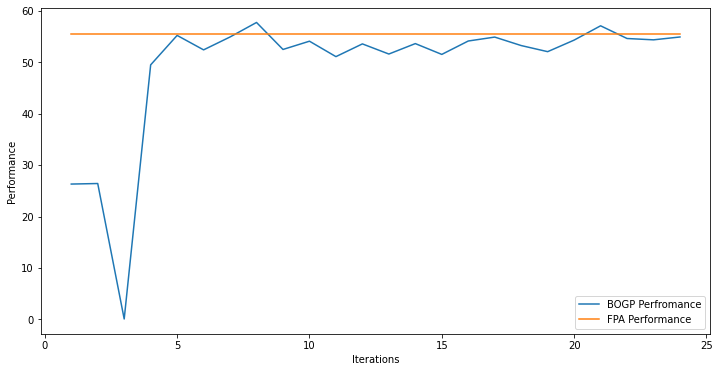

x_next is [ 20.  20. -31.  20.  20.  20.  20.  20. -31.  20.  20. -31.  20.  20.
  20.  20.  20.  20.  20.  20.]
f()=56.189650, actual=54.365
23


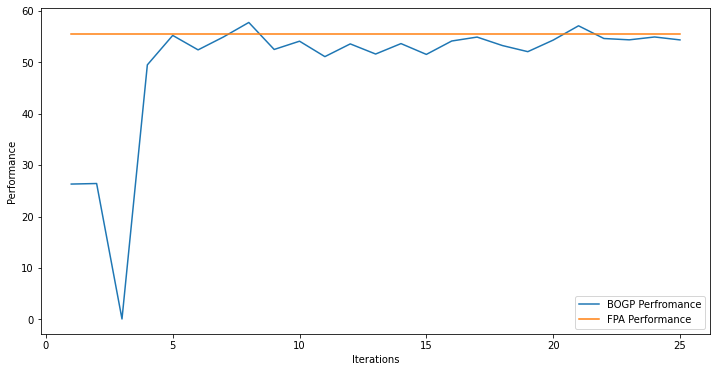

x_next is [ 20.  20. -31.  20.  20.  20.  20.  20. -31.  20.  20.  20.  20.  20.
  20.  20.  20.  20.  20.  20.]
f()=56.421835, actual=54.935
24


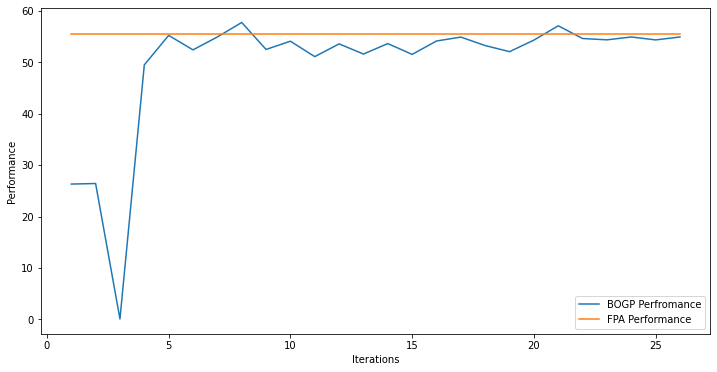

x_next is [ 19.99436532  19.28852008 -30.97505216  19.063851    19.70564581
  19.95235502  19.36083936  19.5396097  -21.88193627  -3.00728691
  15.25929768  19.51716735  19.31077456  16.49818943  17.98314351
  19.99241468  19.91677622  19.94189602  19.98599387  19.95840585]
f()=60.018443, actual=54.872
25


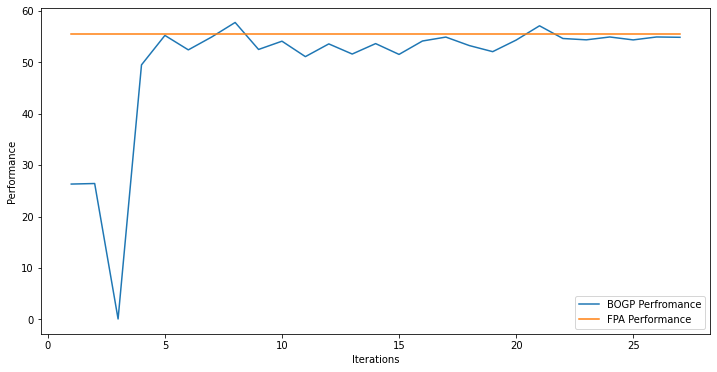

x_next is [ 19.56068606  19.82859982 -29.97945893  19.4431149   19.2892805
  19.91691763  19.89637649  19.55219062 -29.97253059 -22.69054685
  19.03623615 -30.69039454  19.81608157  19.80582091  19.4910023
  18.338256    19.8177249  -30.62979224  19.33763654  19.42108544]
f()=50.577360, actual=50.358
26


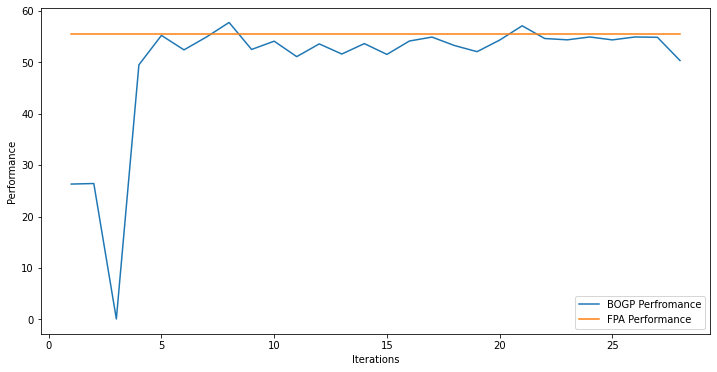

x_next is [ 19.99972211  19.46688598 -30.9996955   19.8277277   19.60746441
  19.85055401  18.70545315  19.9852252  -30.94526657 -13.52012694
  19.63856499 -13.14853433 -27.90023183  19.88598491  19.66321453
  19.99923075  19.84786505  19.99954885  19.75432615  19.56016245]
f()=52.504110, actual=50.830
27


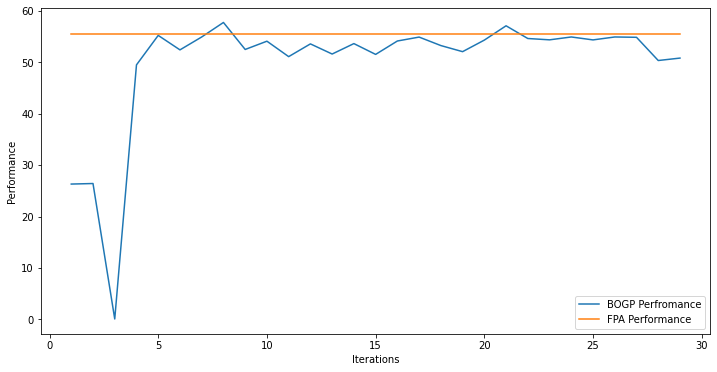

x_next is [ 20.  20. -31.  20.  20.  20.  20.  20. -31.  20.  20.  20.  20.  20.
  20.  20.  20.  20.  20.  20.]
f()=56.146017, actual=54.935
28


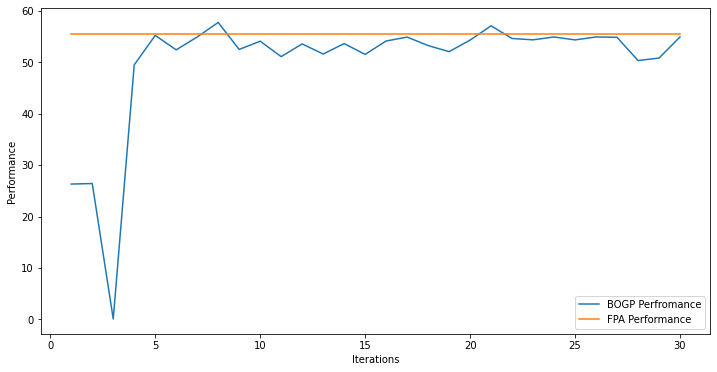

x_next is [-30.56520846  19.7812083  -30.9568826   19.80972912  19.72170579
  19.76335754  19.74942474  19.62810825 -30.96550977  -5.8184037
  19.79585142  18.93328186  19.78699804  19.92410326  19.77088761
  19.70395653  19.96493991  19.71825786  19.80283338  19.68386441]
f()=52.288113, actual=51.469
29


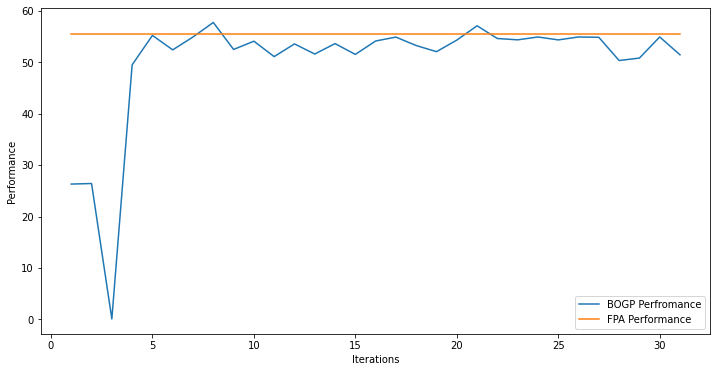

x_next is [ 20.  20. -31.  20.  20.  20.  20.  20. -31.  20.  20.  20.  20.  20.
  20.  20.  20.  20.  20.  20.]
f()=55.119083, actual=54.935
30


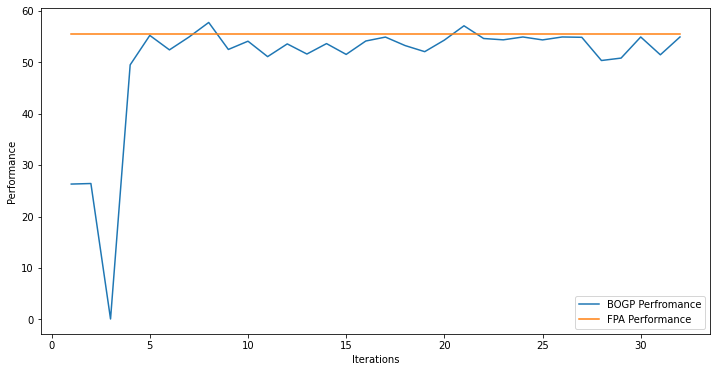

x_next is [ 19.87420883  19.8375276  -30.85968734  19.86862512  19.68902421
 -29.77442159  19.5750697   19.77429356 -30.65767442  -5.09669797
  19.91353604  19.82287567  19.70992492  19.83621533  19.9248894
  19.76062924  19.65125645  19.89977316  19.95855811  19.8783607 ]
f()=52.524143, actual=52.136
31


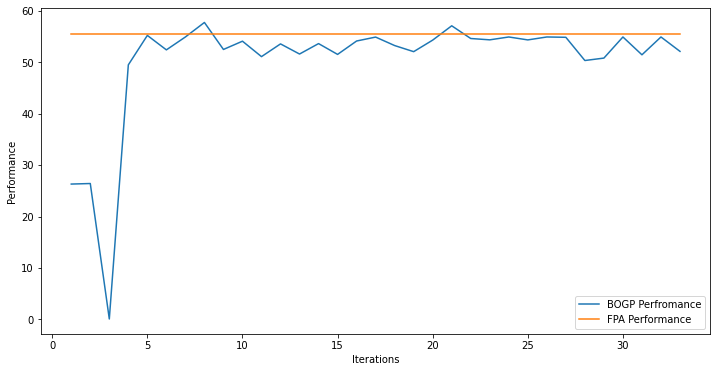

x_next is [ 19.88614356  19.9181778  -30.92634859  19.94355219  19.72441019
  19.86832089  19.88595963  19.7155175  -30.38267994 -18.14963157
  19.95605622 -30.19246218  19.82192842  19.7297602   19.48631351
  19.45825783  19.25021726  19.94733648  19.87703825  18.10441886]
f()=58.161745, actual=53.362
32


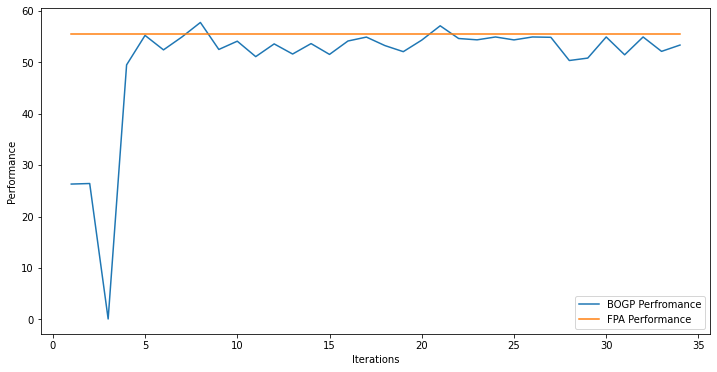

x_next is [ 19.8651501   19.95296006 -30.58705252  19.9013097   19.9649613
  19.92871209  19.94199918  19.97296241 -30.85985443  19.90616078
  19.93416283  19.93228467  19.96051072  19.94133335  19.96783865
  19.910751    19.96268351  19.91711954  19.9921805   19.79633829]
f()=50.305892, actual=54.932
33


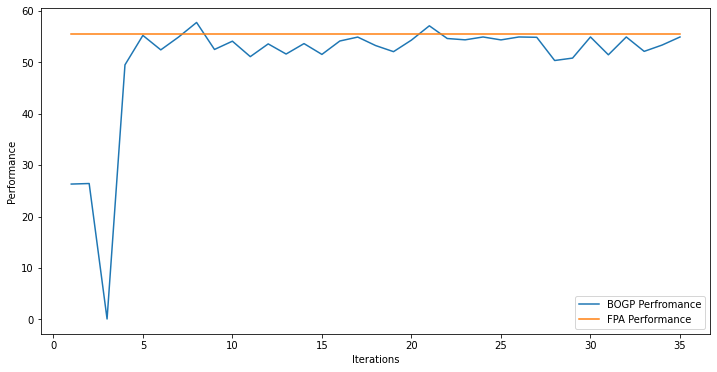

x_next is [ 19.72421348  19.93428608 -30.44744761  19.10445423  19.55134273
  19.63087758  19.98472373  19.26524913 -30.98089305  -2.6704277
  19.92644657  19.83058838  19.83077538  19.78110583  19.8751573
  19.76571456  19.96679121 -17.20354887  19.83838053  19.85507528]
f()=56.221917, actual=52.882
34


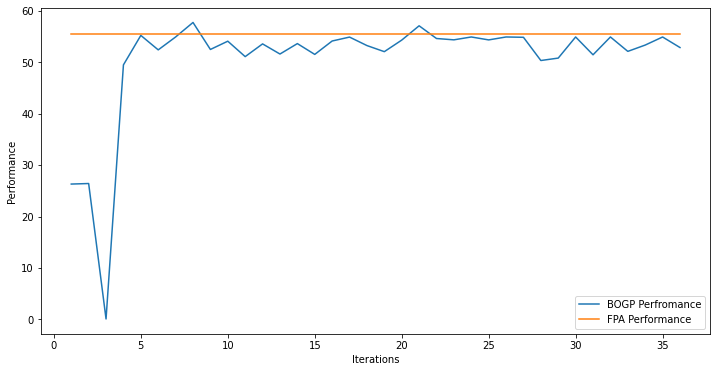

x_next is [ 19.91689402  19.97530518 -30.49296039  19.6254094   19.88323757
  19.94584389 -13.49395645 -15.28847166 -30.81494172 -13.76345195
  19.96610323  19.47699439  19.85862568  19.55446189  19.59834726
  19.80790662  19.81522271  19.86643974  19.63499465  19.72997   ]
f()=53.700388, actual=51.513
35


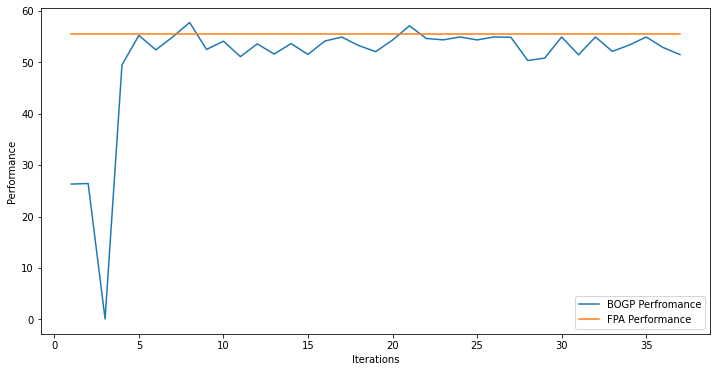

x_next is [ 19.61706928  19.91845913 -30.77370381  19.50817823  19.96028754
  19.85712135 -30.22591304  19.78010132  19.88328299  -4.92734343
  19.55469022  19.65818994  19.95072624  19.99008025  19.91906901
  19.78335785  19.71892991  19.9163243   19.81154199  19.89750123]
f()=51.762303, actual=54.629
36


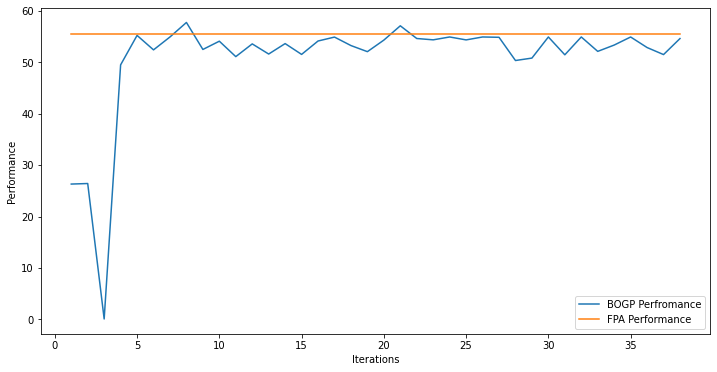

x_next is [ 19.45950455  18.01971133  17.67641512  19.32214039  19.24532617
  19.99662242  19.3197231   17.08078072 -30.74076673   0.69177439
  13.1751143   16.82815105  18.97370888  18.06844514  18.20554689
  19.73929766  15.3348164   18.33990752  18.73572892  15.55407754]
f()=53.715121, actual=54.029
37


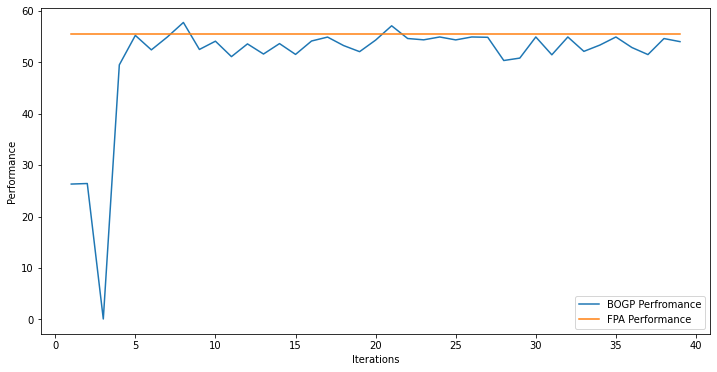

x_next is [ 19.65449942  19.87896279 -30.51993384  19.96439013  19.89020135
  19.87761731  19.56795405  19.99002249  19.54335265  -0.22848048
 -30.92986471  19.94671881  19.98809649  19.66701557  19.94114678
  19.72325524  18.5167088   19.95450335  19.79969675  19.91613127]
f()=51.955253, actual=56.405
38


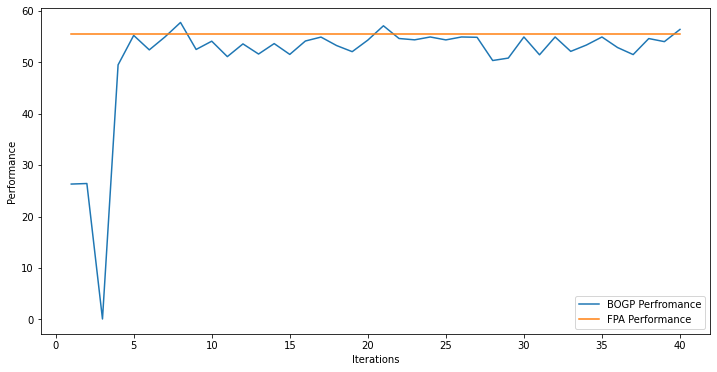

x_next is [ 19.83204069  19.60176943 -30.94036024  19.66502078  19.89580801
  19.94751635  19.61585493  19.96659182  19.65453853   6.66842673
 -30.87536576 -30.10801373  19.97321642  19.78397039  19.87406814
  19.44553232  19.86407273  19.84544496  19.96012496  19.75809795]
f()=51.556943, actual=56.829
39


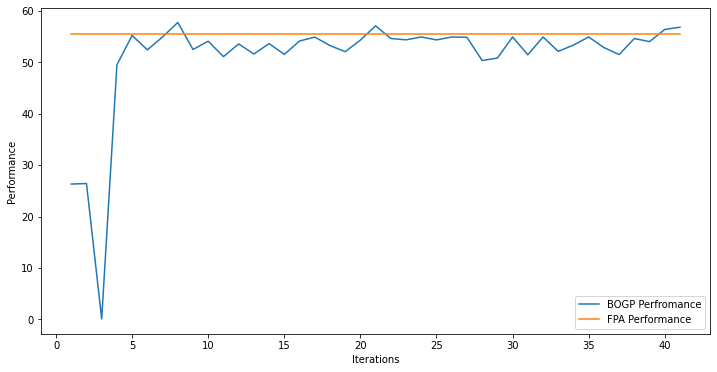

x_next is [ 19.97319285  19.88688921 -30.9796209   19.61190151  19.66247212
  19.84677425  19.98005619 -24.28165706  19.76601749  10.77141721
 -30.87843108  -8.7329233   19.90844304  19.99896439  19.94246531
  19.92912582  19.98006071  19.57014689  19.93758625  19.42841431]
f()=52.508481, actual=55.837
40


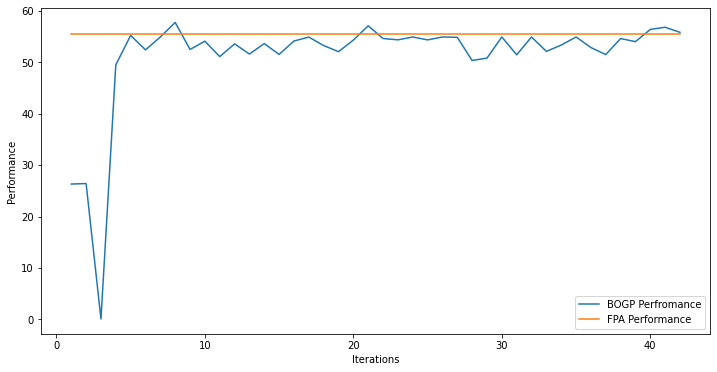

x_next is [ 19.99305358  19.68162377 -30.78190636  19.54549254  19.92846711
  19.84045789  19.46260388  19.43603438  19.67023667   9.06888607
 -30.8278445   -6.49995516  19.72342654  19.97799026 -29.41445571
  19.6878899   19.96315902  19.82692748  19.39340559  19.73574866]
f()=52.265543, actual=56.442
41


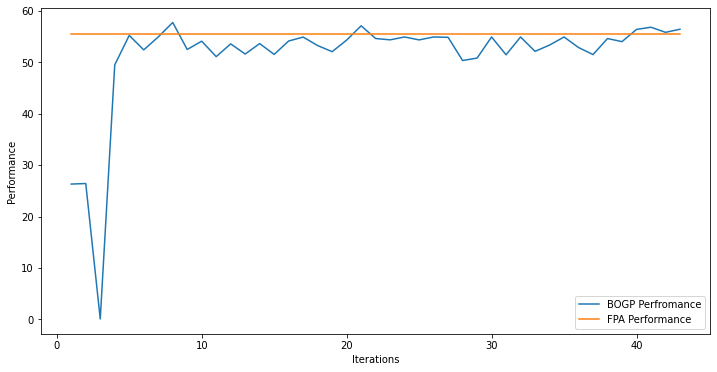

x_next is [ 19.93809747  19.24080605 -30.70312259  19.74548634  19.75940096
  19.8002519   19.63714859  18.87891398  19.94427029   8.74870514
 -30.99517771  -5.69325939  19.94600112  19.93827439  16.60864925
  19.38784662 -18.68952687  19.95872437  19.93082086  19.86773369]
f()=53.557636, actual=54.273
42


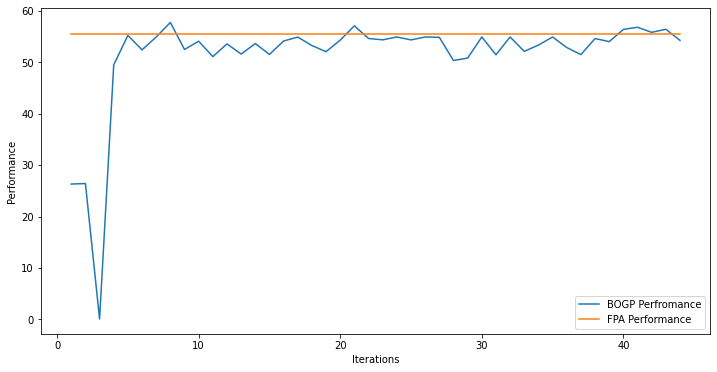

x_next is [ 19.89360889  19.73316318 -30.13040482  19.96393637  19.95965818
  19.82473087  19.88743097  19.75484734 -30.75207432   2.80363807
 -30.87814559 -28.07351264  19.86430226  19.86267965 -14.09285915
  19.91127948  19.93842684  19.98587586  19.91027544  19.86173739]
f()=53.968412, actual=55.017
43


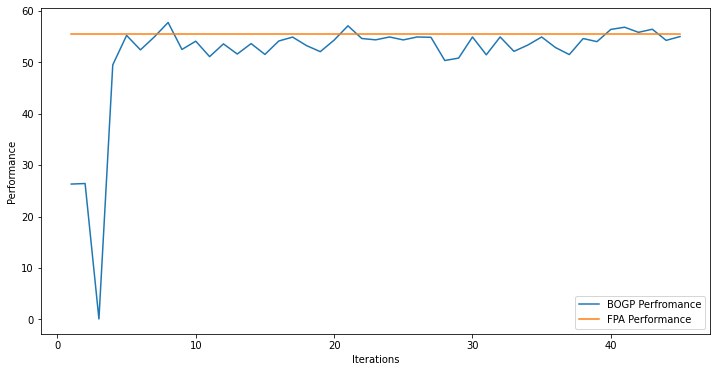

x_next is [ 19.45934166 -26.34547288 -30.97351303  19.76581879  19.9626267
  19.70743639  19.90487301  18.5122852   19.45265173  12.50135925
 -30.23316383  -6.29696314  19.99558908  19.38121199  18.66701023
  19.50983495  19.55224145  19.30166214  19.98485248  19.90552701]
f()=52.432252, actual=55.546
44


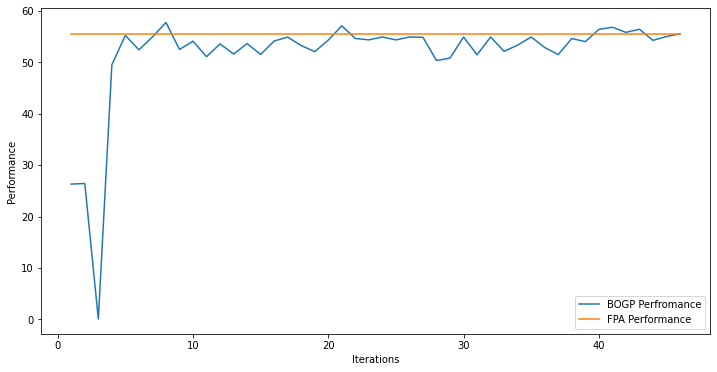

x_next is [ 19.76154455  19.49542929 -30.74310923 -28.62794926  19.94226694
  19.9404248   19.54717545  19.75299046  19.42315106   7.89289502
 -30.99263981 -11.04470711  19.83932182  19.87815345  19.02896194
  19.76635616  19.99874733  19.64554998  19.91914813  19.843388  ]
f()=52.708618, actual=54.759
45


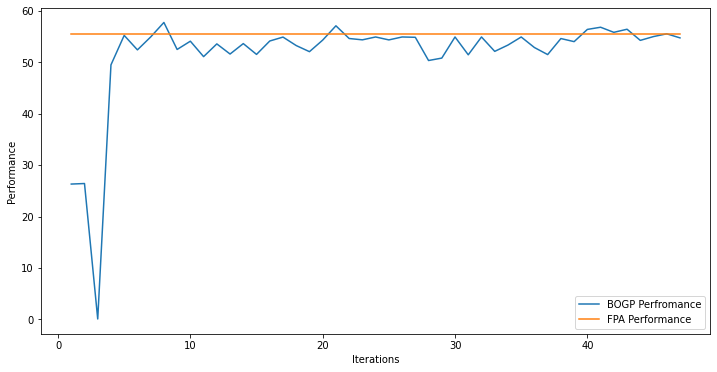

x_next is [ 19.62675548 -21.15232069 -30.63896026  19.28573833  19.99673897
  19.81000236  19.9226402   19.87507147  19.48619903  -4.3677001
 -29.99516472  19.77497669  19.98158994  19.9626872  -30.89393124
  19.74652378  19.90317307  19.58390035  19.83985518  19.57669269]
f()=52.984408, actual=53.956
46


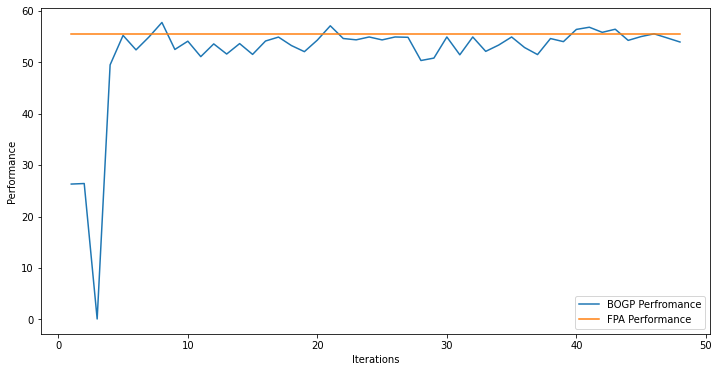

x_next is [ 19.8548934   19.89647827 -29.91271902  19.20829633  19.96934867
  19.73804982 -28.55514052  19.66846362  19.85007722  18.54728645
 -30.73899348 -11.95727081  19.54759581  19.75487485  19.07998296
  19.95818899  19.90870692  19.89964929  19.84220604  19.79045198]
f()=53.645524, actual=53.901
47


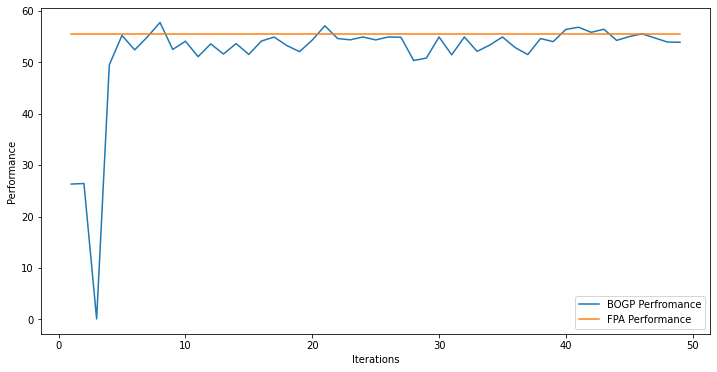

x_next is [ 19.98283407  19.93660863 -30.52256762  19.22081985  19.97967339
  19.97338795  19.93054615  19.57886522  19.89332428  16.53611605
 -30.71022778  -8.63770148  19.76806539 -30.54041972  18.41951241
  19.87235686  19.8649187   19.52225305  19.71777873  19.98925838]
f()=52.248444, actual=54.947
48


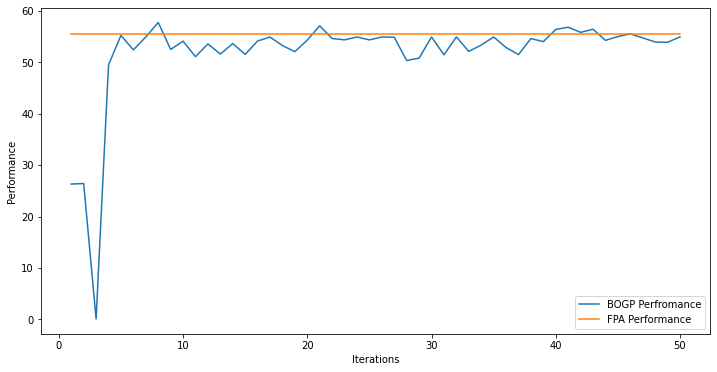

x_next is [ 19.99938104  19.99954654 -30.99969711  19.99963354  19.99987311
  19.99836909  19.9997854   19.99880677  19.9964844   19.99809043
 -30.99708513  19.99946341  19.99947003  19.99934223  19.99745586
  19.99986128  19.9993757   19.99996991  19.99944128  19.99915064]
f()=57.276513, actual=55.308
49


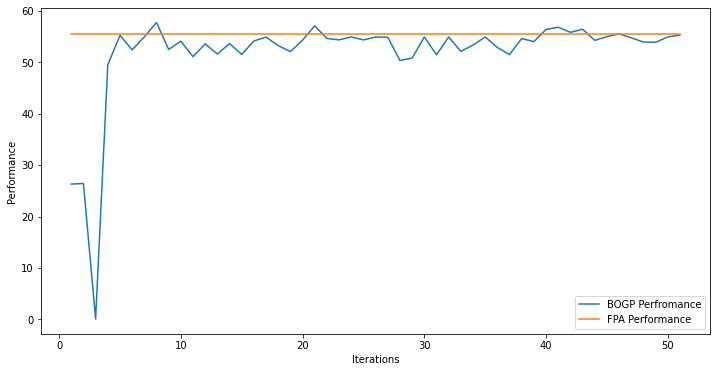

x_next is [ 19.83099682  19.15824626 -30.68678428  19.91149732 -29.0747005
  19.92470851  19.78791439  18.76040301  19.93432722  -0.75043717
 -30.98222011  -9.92741697  19.91122074  19.56815661  19.94472249
  19.85632495  19.9934527   19.90334644  19.47636405  19.84587875]
f()=51.835156, actual=52.016
50


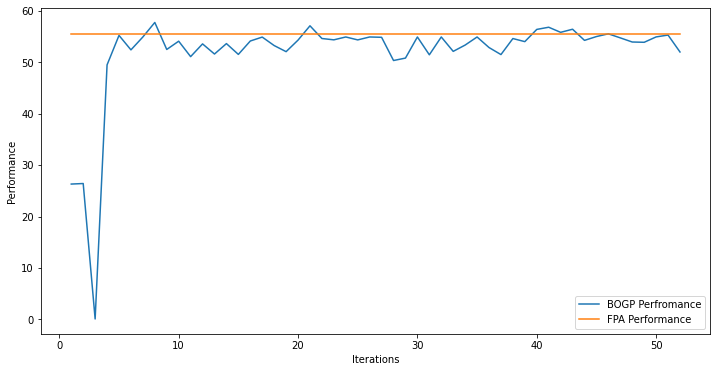

x_next is [ 19.97040569 -17.33423273 -30.74542127  19.51348584  19.93429433
  19.85171301  19.48692274  19.54287485 -30.37289136  -0.59708302
 -30.47782864 -30.96422071  19.7917073   19.78029173  19.9572278
  19.9850871   19.86332918  19.98379644  19.46331102  19.99199194]
f()=53.798796, actual=53.880
51


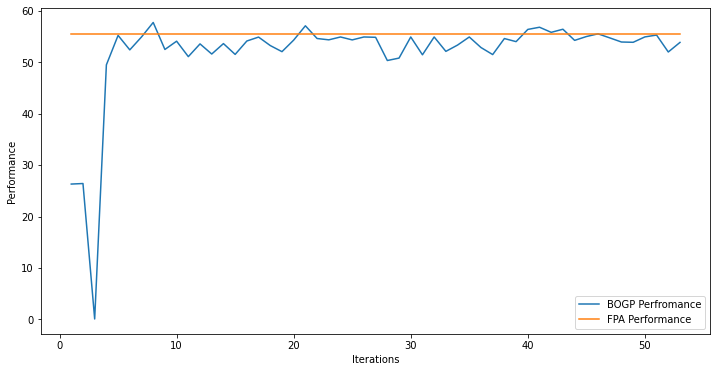

x_next is [ 19.95378643  19.75506165 -30.87275217  19.59413832  19.93076516
  19.93389802  19.97832389  19.40331502  19.82899397   0.87214534
  19.79607879 -30.47347936  19.97142899  19.85232059 -25.34048478
  19.81146192  19.99885071  19.50493934  19.96107846  19.78640078]
f()=53.647780, actual=55.281
52


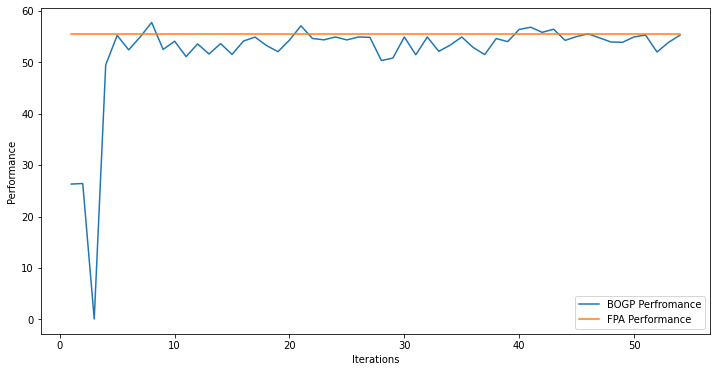

x_next is [ 19.72414909  19.45500627 -30.97177832  19.81092287  19.77130672
 -27.80299283  19.61131316  19.85968831  19.17304579   1.59606651
 -30.41786246 -30.48260964  19.77382152  19.94810526  16.68188967
  19.54051847  19.5211381   19.64323713  19.98590159  19.98872199]
f()=50.904522, actual=52.590
53


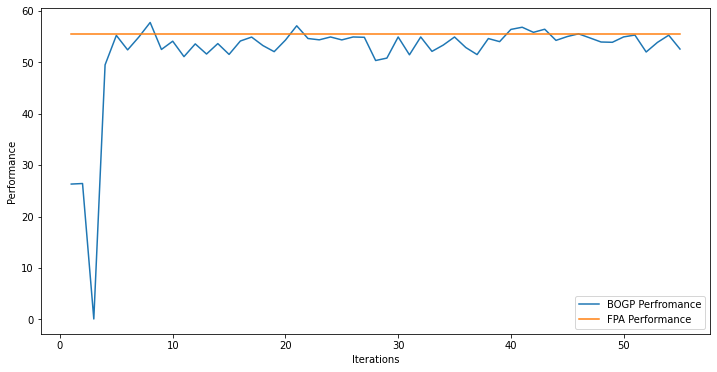

x_next is [ 19.78787157  19.96570823 -30.98683225  19.95487174  19.9568467
  19.91668746  19.65841851  19.81409206  19.87507178  -1.91823679
 -30.82746249 -15.44357036  19.6632994   19.96286568  19.01566188
  19.85947214  19.68626082  19.58937613  19.87743605 -27.42343891]
f()=52.156337, actual=52.174
54


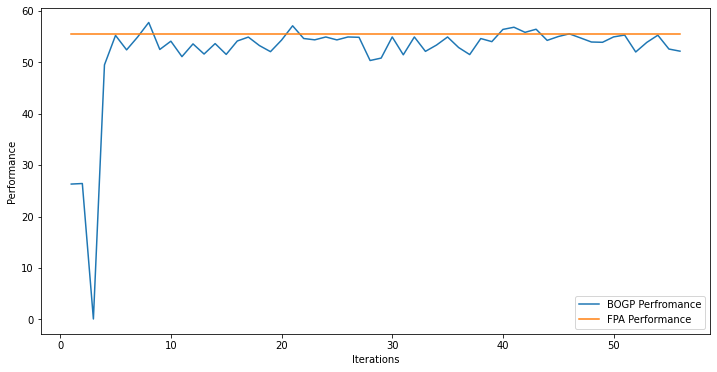

x_next is [ 19.7757785   19.6914448   16.18035175  19.81727062  19.86620135
  19.90020406  19.99671147  19.98967313  19.78601007   0.28178745
 -30.99499122 -30.74569709  19.83026257  19.85319822  19.46574662
  19.95430034  19.64460177  19.6950749   19.8154355   19.87197405]
f()=52.383387, actual=55.792
55


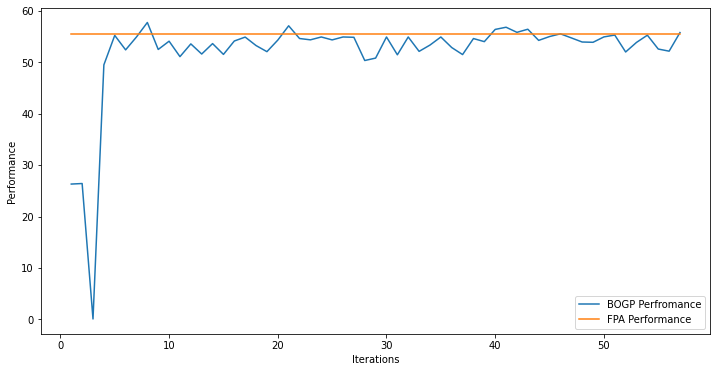

x_next is [ 19.61695875  18.9063601  -30.51720881  19.70723703  19.78272916
  19.99944719  19.02612787  19.65763728  19.71550068 -11.69994318
 -30.72998852 -30.58826253  19.97819871  19.68846258 -10.61164814
  19.92442981  19.91159131  19.87761843  19.94601937  19.90567586]
f()=56.368038, actual=53.126
56


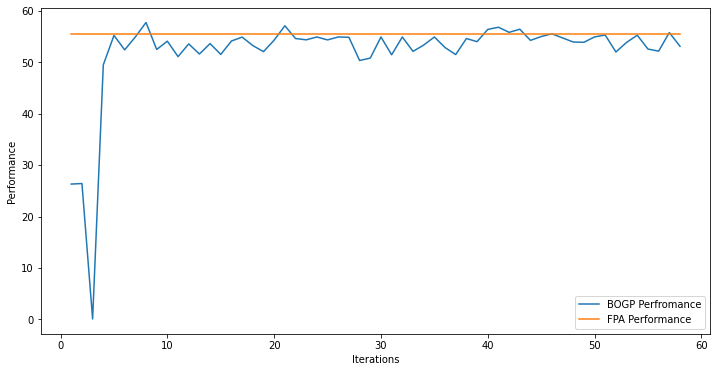

x_next is [ 19.46708955  19.3368996    0.91880782  19.9108783   19.98931757
  19.7491098   19.79680239  19.21821873 -30.75320973   6.62034338
 -30.54547116 -17.63347205  19.74548381  19.88364023  19.89594669
  19.98073856  19.11381699  19.085222    19.5523736   19.57144353]
f()=55.794831, actual=56.354
57


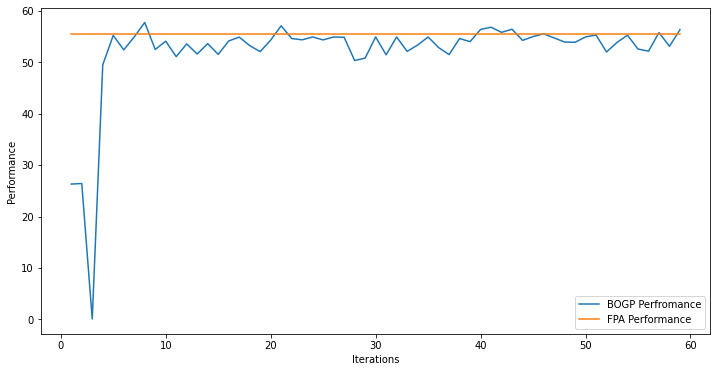

x_next is [ 19.73167247  19.90713909 -30.72804507  19.7346759   19.84292424
  19.76157662  19.85416053  19.83544875  19.91838548  -0.47063515
  18.77514625  19.93208099  19.74109255  19.82896737 -30.53767167
  19.86197076  19.59824595  19.87944004  19.65692866  19.39751949]
f()=55.547091, actual=55.772
58


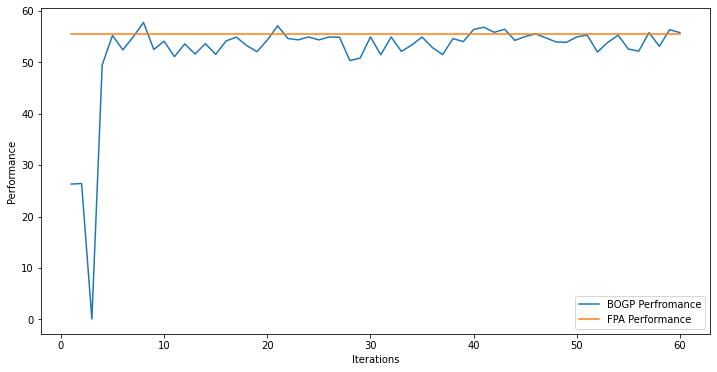

x_next is [ 19.86581018  19.43922115  14.67729196  19.85317054  19.94909671
  19.26166818  19.98952008  19.54406395 -30.7074429    6.0206261
 -30.80970152  18.90693061  19.99656763  19.74550999 -30.74731214
  19.38219241  19.9951937   19.97900693  19.8024171   19.98968883]
f()=52.872508, actual=56.675
59


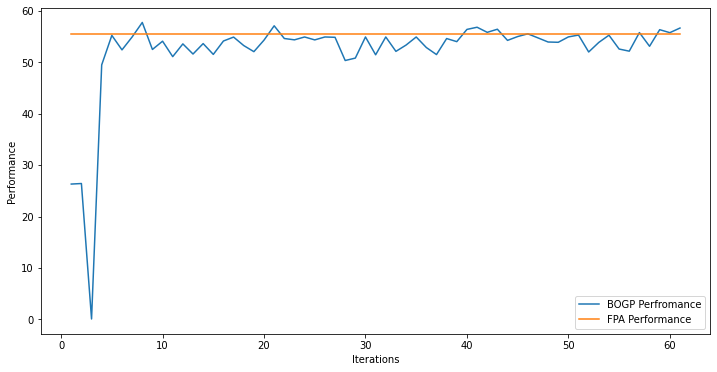

x_next is [ 19.8164015   19.98321238  14.26429164  19.39232703  19.94546164
  19.79501118  19.70577494  19.07516264  19.78484903  19.71329975
 -30.78697532   4.1743001   19.80296616  19.96005463 -30.74377377
  19.99982119  19.84064033  19.99940741  19.89652514  19.99795215]
f()=55.521494, actual=53.990
60


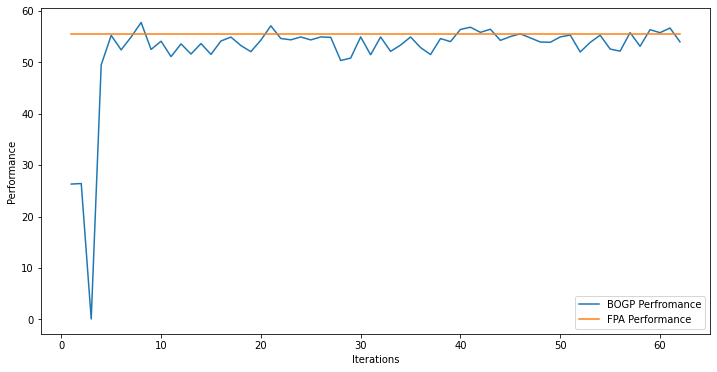

x_next is [ 19.92592261  19.88757997  17.77258608  19.40973542  19.96185682
  19.97927555  19.68126077  19.80290719 -30.8908156  -12.27545155
 -30.51741907  19.78697448  19.90037783  19.93896785  19.43047101
  19.82663773  19.6556383   19.60584615  19.91125726  19.92610022]
f()=55.797228, actual=55.028
61


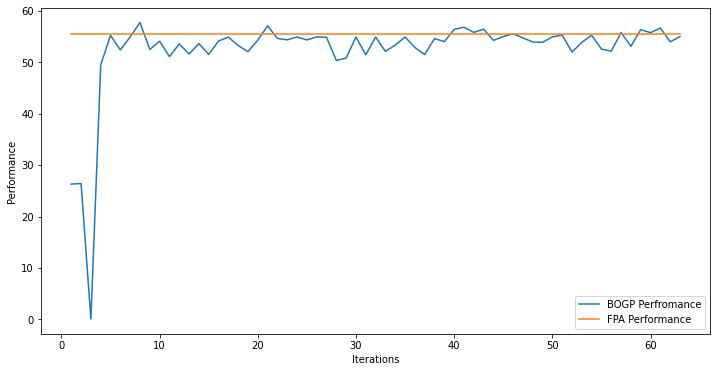

x_next is [ 20.  20. -31.  20.  20.  20.  20.  20.  20.  20. -31. -31.  20.  20.
  20.  20.  20.  20.  20.  20.]
f()=57.315595, actual=54.508
62


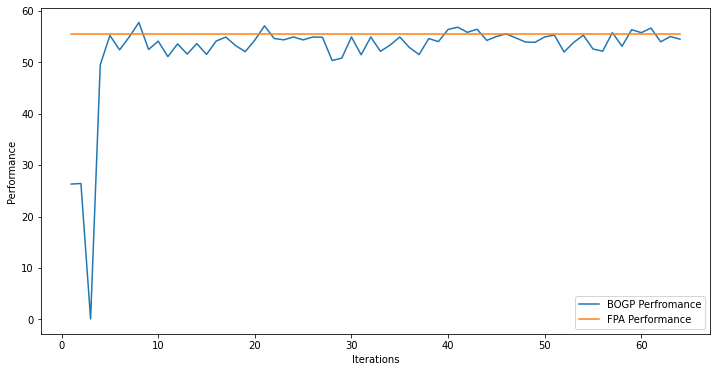

x_next is [ 19.82010887  19.9375175  -25.35144055  19.85186279  19.98225545
  19.71154786  19.32903491  19.63141939 -30.02884276  -0.913206
 -30.92293487  17.86085687  19.76734707  19.8662659  -30.51979216
  19.09205735  19.68809285  19.92946537  19.65687003  19.70691373]
f()=56.514637, actual=54.962
63


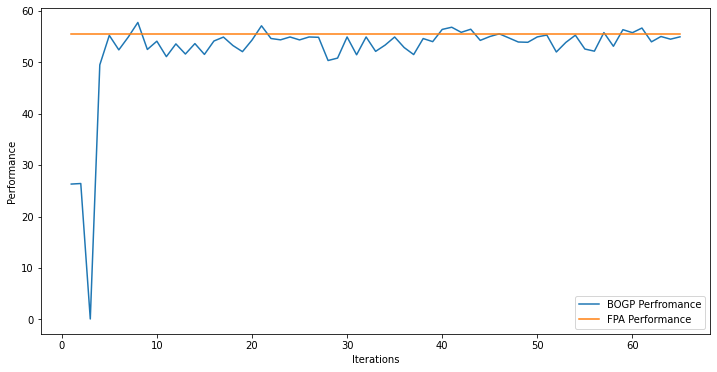

x_next is [ 19.74812489  19.68720938 -30.66910477  19.89475835  19.92303341
  19.94001915  19.77323131 -27.10421385  19.57115102  14.92906927
 -30.21396343  18.99746816  19.9297859   19.64369801 -30.80710185
  19.04829554  19.68777888  19.91736554  19.82801523  19.69062129]
f()=53.638571, actual=55.104
64


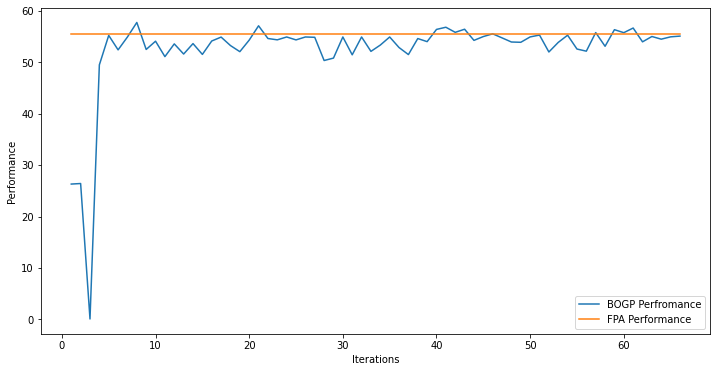

x_next is [ 18.02510572  18.28635053  19.5524078   19.86594615  19.53962537
  19.39210572  18.77577227 -29.30379416 -28.63786659  15.87517813
 -28.95305165 -30.35279533  17.60375666 -30.60059106 -30.54813671
  18.84075794  18.74316102  19.48132154  19.70171035  19.32872266]
f()=46.144915, actual=51.467
65


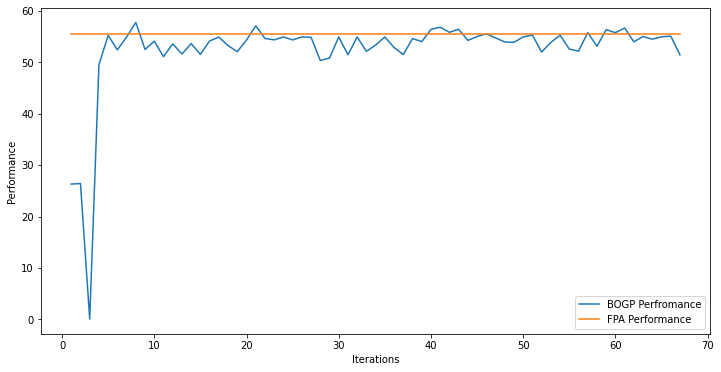

x_next is [ 19.71361947  19.96632068   2.2332429   19.8646667   19.96555352
  19.74616759  19.80059796  19.14103885 -30.52400969  16.52075723
 -30.97884952  17.65333186  19.87478157 -30.82420563 -30.340158
  19.83107937  19.80020314  19.94526744  19.9251152   19.70916721]
f()=54.236380, actual=54.125
66


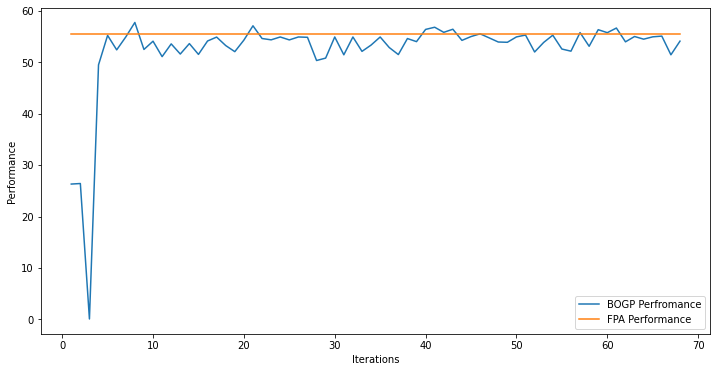

x_next is [ 19.74971577  19.96365686  17.82980566  19.3828326   19.91005328
  19.66536213  19.59323895 -30.43730763 -30.34167926  19.70148647
 -30.93278731  18.03329232  19.82795212  19.95081875 -27.96279296
  19.27716263  19.14197713  19.96451727  19.88131166  19.84349872]
f()=53.975659, actual=52.815
67


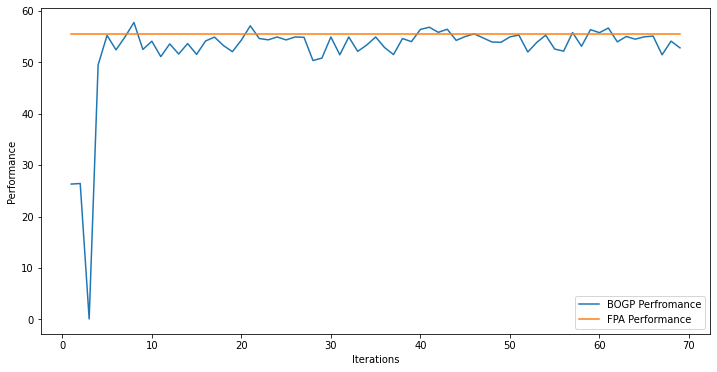

x_next is [ 19.78870513  19.49395534 -30.9147825   19.66435095  19.86912525
  19.93026342  19.94427388  19.65587901  19.90374817  12.59768828
 -30.29575872  17.89491418  19.77736744  19.7930474  -30.07911548
 -26.3018291   19.48858564  19.81236043  19.56905125  19.86651167]
f()=51.577224, actual=53.749
68


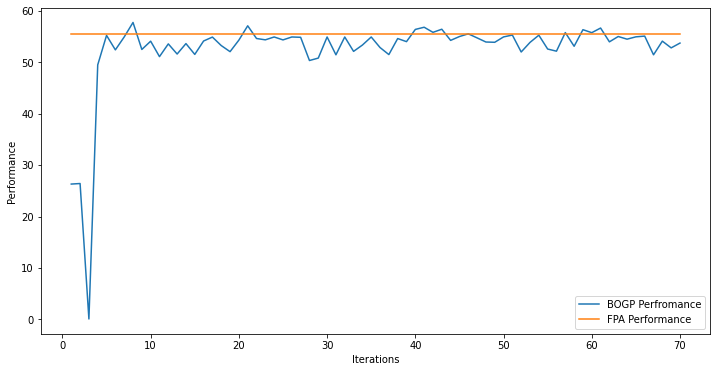

x_next is [ 19.98057903  19.39594702 -30.52623465  19.4683833   19.64165296
  19.83951147  19.82563594  19.28098795  19.12988227   0.41347316
  19.17811394 -25.99183147  19.74025946  18.79750898  19.97668273
  19.91195467  18.99811369  19.46429363  19.74340523  19.98529727]
f()=56.367818, actual=55.643
69


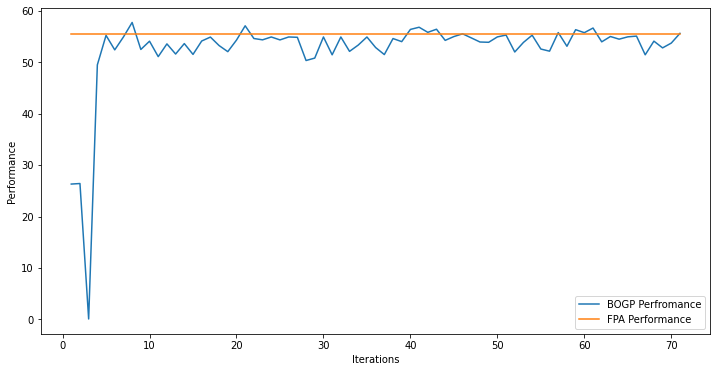

x_next is [ 19.37921482  19.98974387 -29.65575743  19.98712323  18.58019439
  19.31390251  19.67473522  19.22061874  19.42397396  19.69269755
  18.66435564  19.40337711  19.91384496  19.76453833  19.34956788
  19.90794788  19.14752708  19.95421883  19.95382416  19.74453581]
f()=52.505723, actual=54.743
70


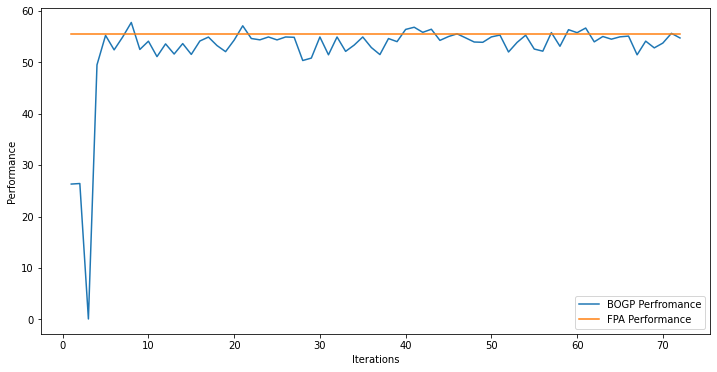

x_next is [ 19.45231967  19.30384804  19.4720853  -30.44814766  19.24891144
  18.45615222  19.90442692  18.03161029 -30.82065052  14.7207926
 -30.55299367 -28.83678546  17.4324995   19.93668915 -29.36979823
  19.76931242  19.79785322  17.62945168  19.33430816  18.74588166]
f()=49.710360, actual=52.607
71


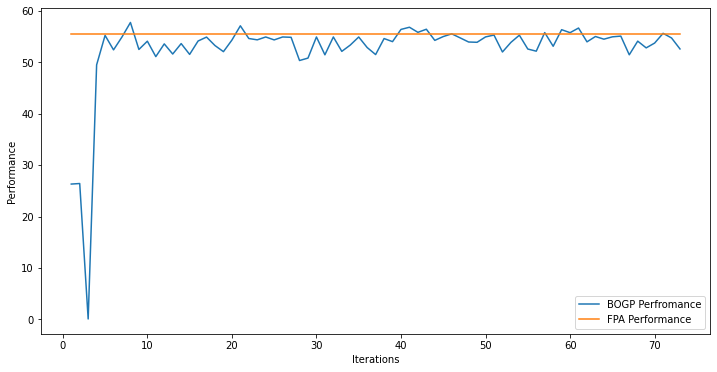

x_next is [ 19.79566044  19.81948925 -30.9111085  -24.24343423  19.67924615
  19.86451011  19.76664755  18.0738391   19.52131329  12.25202597
 -30.71750534  19.97062925  19.77693533  18.28622865 -30.94110194
  19.49303637  19.86081444  19.5205109   19.16511856  19.87274029]
f()=53.988684, actual=55.663
72


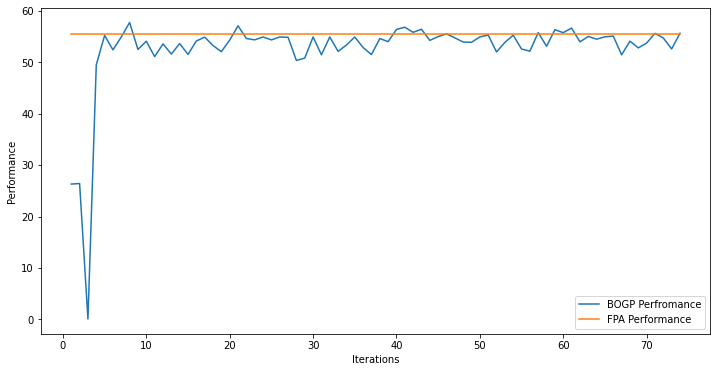

x_next is [ 19.95332682  19.9640016  -30.42193179  19.40373813  19.96310269
  19.94567484  19.52124321  19.17024275  19.18298423  13.36716389
 -30.97119674  19.02073115  19.83834484  19.99496347 -30.77782687
  19.77693435  19.87907891  19.88663893 -29.36394252  19.96552915]
f()=51.173510, actual=52.387
73


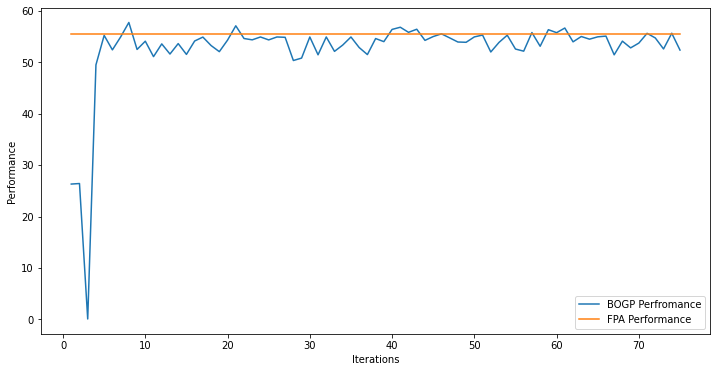

x_next is [ 19.99987647  19.99971709 -30.99987722  19.9999444   19.99994691
  19.99984783  19.99980581  19.99994917  19.99973932  19.99968325
  19.99963983  19.99960968  19.99986026  19.99991663  19.99960068
  19.99989183  19.99999305  19.99997938  19.99998848  19.99986012]
f()=52.578281, actual=55.240
74


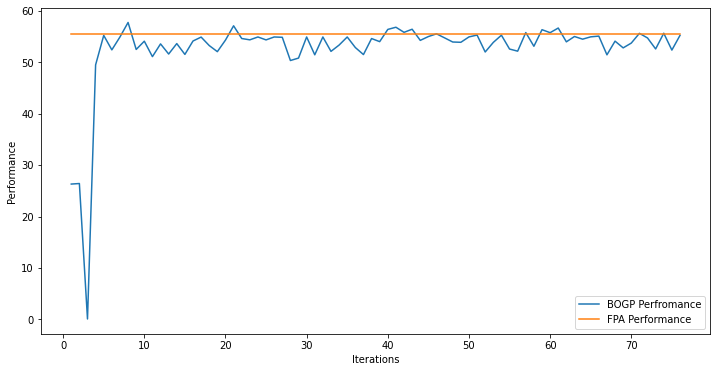

x_next is [ 18.12264432  19.86328518 -24.73326452  14.91395685  19.1652466
  19.46366672  17.29624627  13.98462399 -27.92818433  15.3898119
 -28.7156669  -27.91388166  14.6387874  -21.41422755 -23.53068328
 -22.29844153  16.63251721  18.88584184  16.27129569  19.08158627]
f()=48.280257, actual=49.794
75


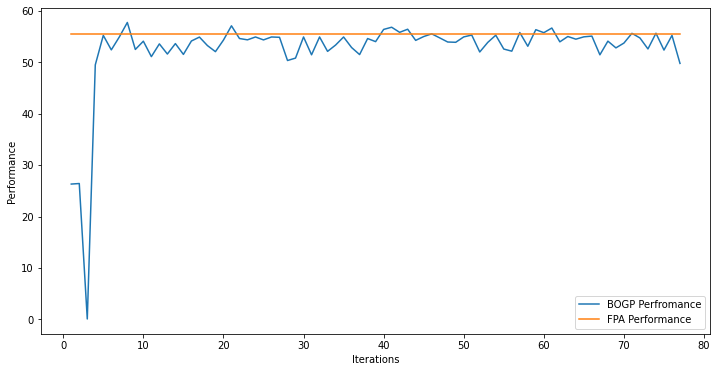

x_next is [-30.80792621  11.93179542  -4.09808847   9.91566413   5.24137114
   7.86245028  13.70801002  -4.20587011  12.18270894  -6.29822143
  -2.26800059  19.93393066   1.87538108 -22.1829644   -4.00327899
   2.21880275   9.62753758   1.77221424 -11.34800461   5.29646913]
f()=52.577035, actual=31.458
76


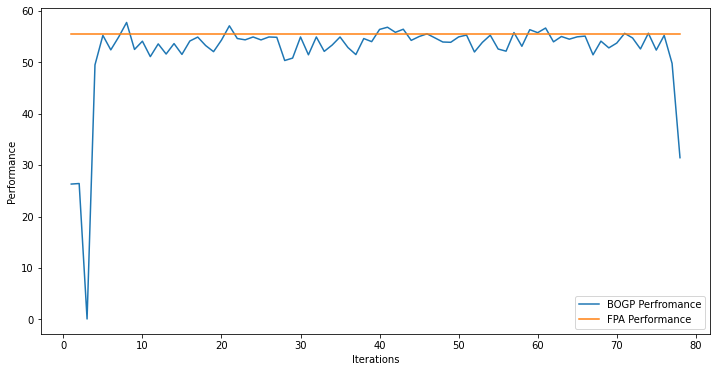

x_next is [ 19.14300175  18.58365307 -30.41617979  19.95192688  19.83515516
  18.88257523  18.891155    18.12088107  19.63238771  18.35146399
 -29.92112384  19.87778831  19.81162814 -29.93340656 -29.87079851
  19.76600779  19.83877133  19.72118452  19.73182999  19.91048457]
f()=54.355987, actual=53.515
77


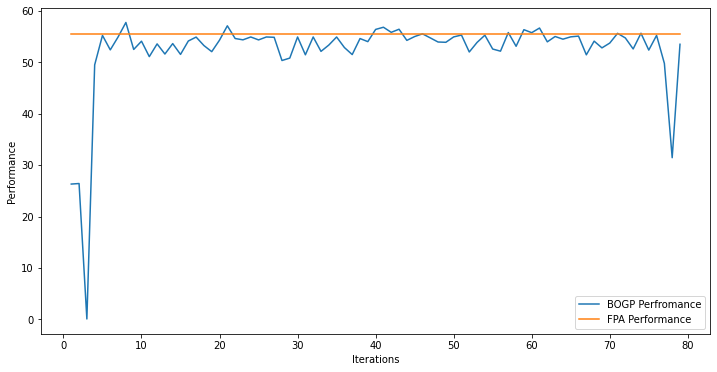

x_next is [ 12.23139985  15.27102514  18.65162402  -8.88482578 -11.46991327
 -26.43070044 -30.2485796   17.56471265   3.3508579    8.63061265
 -24.08725749  12.29306624 -28.35547335  17.2389456    7.25238794
 -16.45371503 -11.44099627 -28.60144631  15.10481703   6.9671776 ]
f()=52.320517, actual=32.866
78


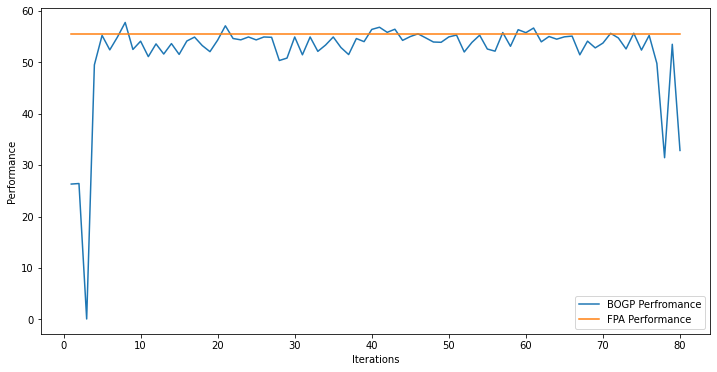

x_next is [ 19.94608483  19.77656289  18.92129488  19.67828067  19.99930226
  19.28738414  19.88237496  19.82141298 -30.69822918  14.0226175
 -30.70412194  19.36471833 -30.37532584  19.99808517 -30.7933791
  19.76105275  19.50332669  19.69320198  19.98068898  19.94811502]
f()=51.690325, actual=53.962
79


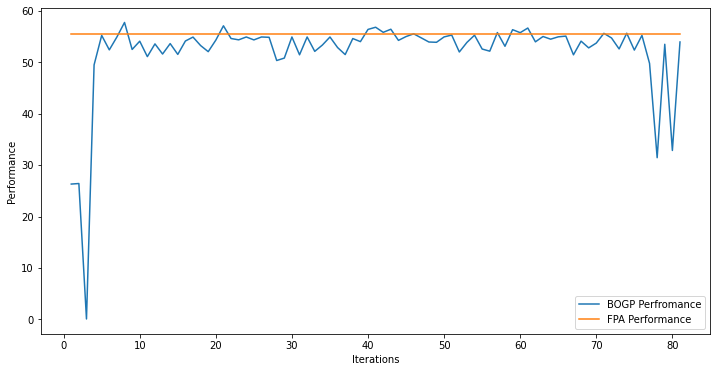

x_next is [ 19.93115622  19.92558935 -30.87145925  19.71730985  19.95991572
  19.81125544  19.86366957 -30.66934424 -30.71187266   6.84836989
 -30.9310111   19.42043831  19.89918021 -30.97755839  19.86130101
  19.86966264  19.9577739   19.91306973  19.70360549  19.8489384 ]
f()=52.580234, actual=54.555
80


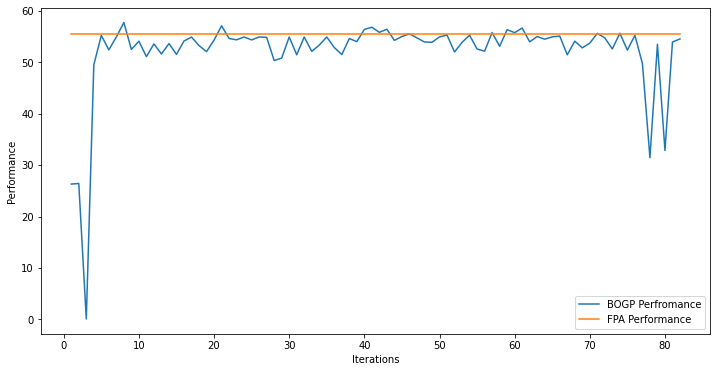

x_next is [ 19.73494749  19.46765007 -30.93664192  18.63303993  19.99430338
  19.33513357  19.47775198  19.83022918  19.03353776   9.78308168
 -30.22446746  19.29439583 -23.83804745  19.37499266 -29.75803747
  19.71832963  19.46977174  19.74528829  19.8463048   19.45120694]
f()=54.119219, actual=54.807
81


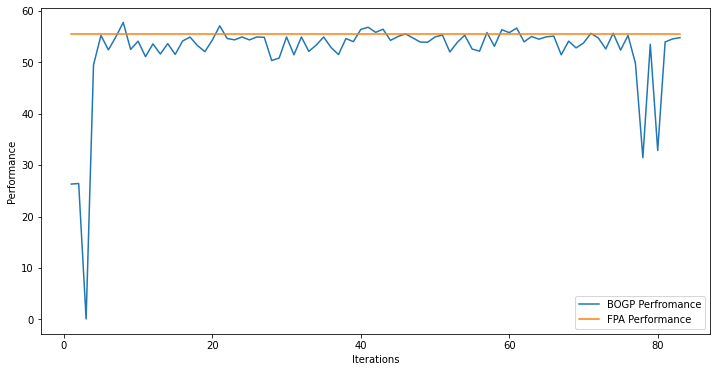

x_next is [ 19.99584023  19.99408109  17.95472341  19.60440121  19.86187072
  19.96632318 -29.58626251  19.98123704 -30.86163822  16.70411545
 -30.8663837   19.35180861  19.82850739  19.66631487 -30.84739454
  19.91208799  19.86749521  19.98603351  19.69875755  19.8529001 ]
f()=52.888195, actual=54.678
82


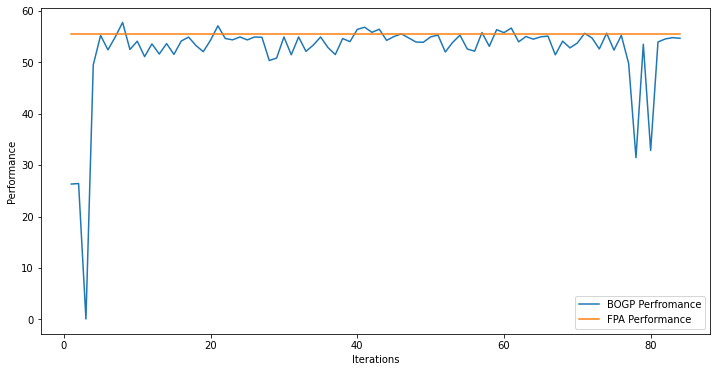

x_next is [ 19.61519672  19.86584687 -30.89131072 -30.90556854  19.83559926
  19.95083593  19.9889574  -29.53996815  19.74099088  14.34046803
 -30.96081223  19.78820952  19.87080123 -30.68339344  19.4706533
  19.53343133  19.97444206  19.84232535  19.50250321  19.89373621]
f()=50.991609, actual=52.804
83


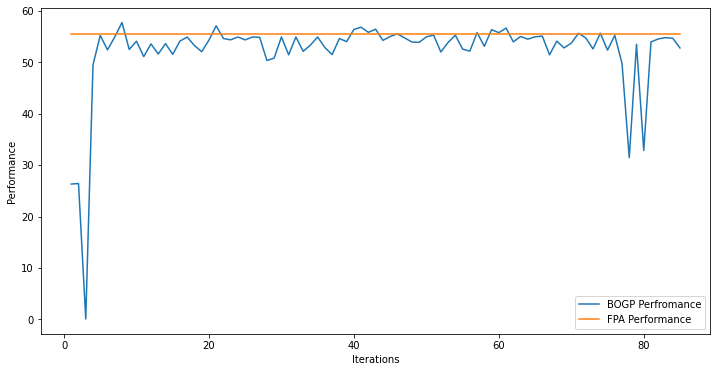

x_next is [ 20.  20. -31.  20.  20.  20.  20.  20.  20. -31. -31.  20.  20.  20.
  20.  20.  20.  20.  20.  20.]
f()=56.523218, actual=55.007
84


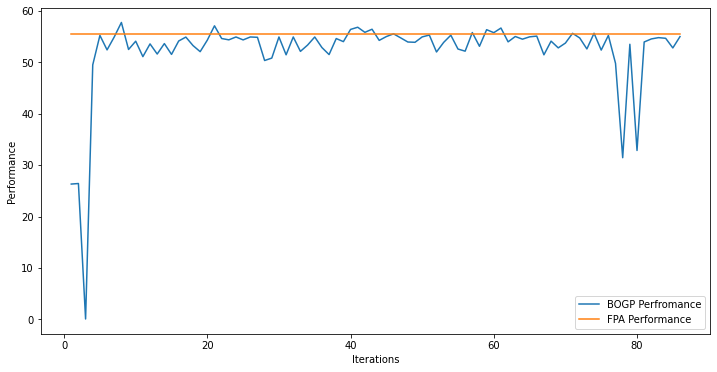

x_next is [ 19.87234581  19.97408099  19.81064391  19.89092625  19.75123282
  19.83813669  19.94141827  19.56520127 -29.46407127  18.25084786
 -30.67458584 -27.33797538  19.51397466  19.66057522 -30.01322764
  19.67176814  19.70353012  19.99384149  19.85897482  19.99223215]
f()=55.542255, actual=54.294
85


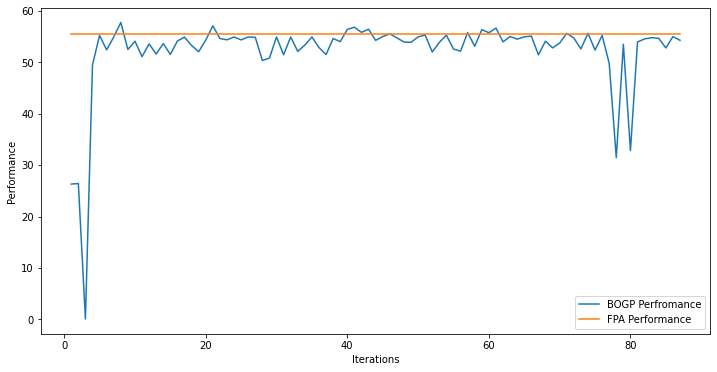

x_next is [ 19.858122    19.98340825  -0.84720131  18.53832304  19.72340118
  19.95263015  19.16839389  18.9078087  -30.88542906   1.6166246
 -30.90157745 -30.55535755  19.81101782 -30.79494109  19.95868739
  19.41469227  19.71012348  19.42323171  19.96484527  19.99967283]
f()=54.709467, actual=54.025
86


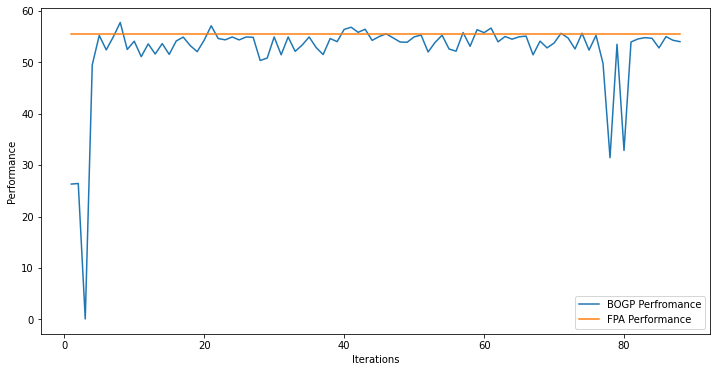

x_next is [ 19.7392786   19.18643113 -30.65551656  16.49237429  19.78964969
  19.4325337  -30.60577243  19.28665653  19.80762044  17.81325911
 -29.8365942   19.57913804  18.62394602  19.53530681 -30.90251138
  19.63198926  19.45656378  19.86952609  19.47350478  19.68930957]
f()=54.284653, actual=54.976
87


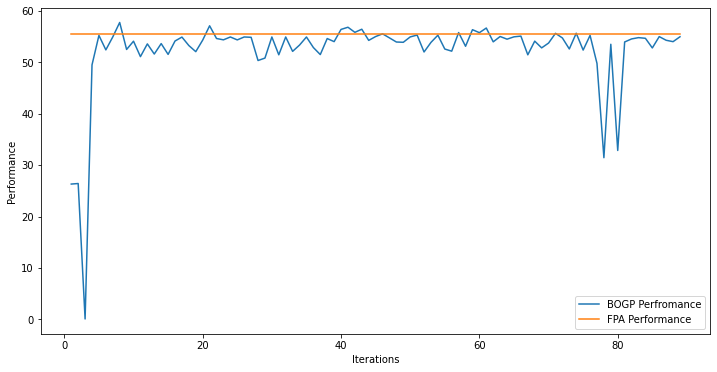

x_next is [ 20.          20.         -31.          20.          20.
  20.          20.          19.99997266  20.          20.
 -31.          20.          20.          20.         -31.
  20.          20.          20.          20.          20.        ]
f()=56.804553, actual=54.518
88


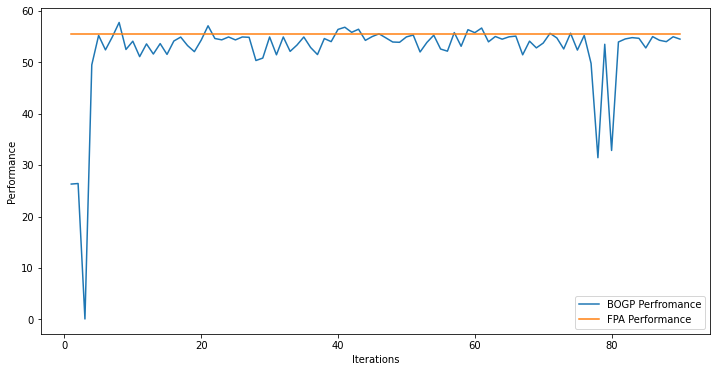

x_next is [ 19.75081291  19.61225151 -30.50935634 -28.27489117  19.86885605
  19.49804726  19.97833306 -30.15668473  19.69333134  12.93139614
 -30.21390491  -8.56632412  19.65042155  19.54569988 -30.84706763
  19.38148477  19.82411283  19.72290012  19.95172044  19.9912478 ]
f()=53.426739, actual=51.722
89


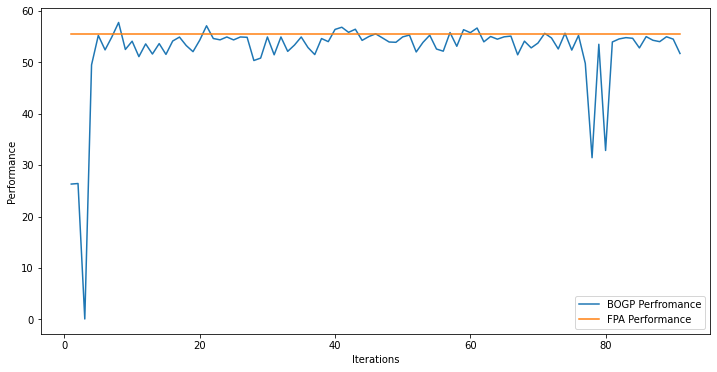

x_next is [ 19.71333395  18.8042904  -19.3770487   18.19583985  19.71262791
  19.44383176  19.81256958  19.67362021  19.77374994   0.15795294
 -30.6127845  -10.46723651  19.10878556  19.7820436   19.50644325
  19.16972371  19.88446464  19.73040056  18.86130679  19.29009808]
f()=57.240743, actual=56.148
90


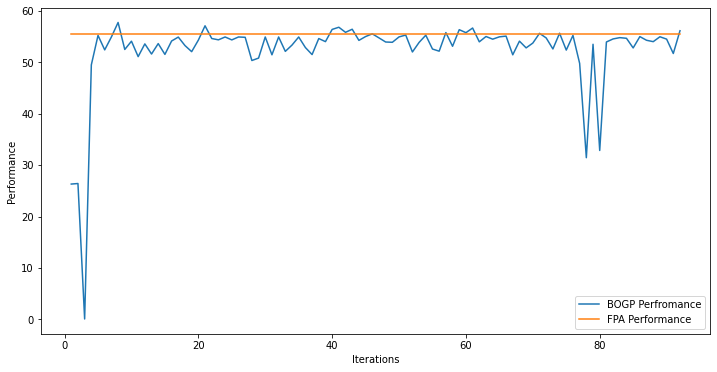

x_next is [ 19.97498834  19.97738677 -30.18325994 -30.86431969  19.81015767
  19.72212665 -30.72647962  19.68310234  19.8364359   12.53239343
 -30.59659927  19.90867323 -30.82060235  19.19540226 -30.06736792
  19.42131638  19.61611173  19.93750079  19.42936523  19.36468569]
f()=51.375141, actual=51.789
91


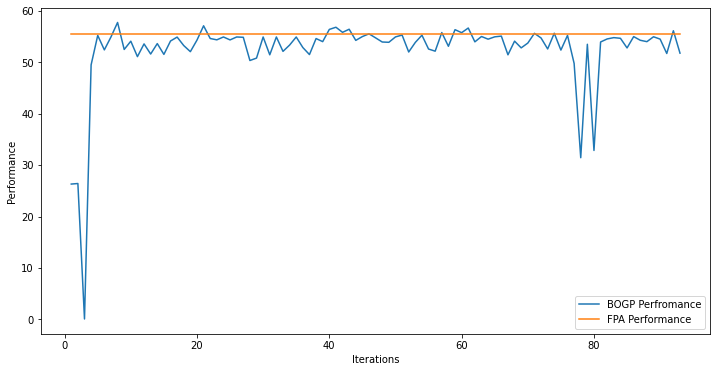

x_next is [ 19.70624677  19.8193865   19.69152041 -30.61274102  19.68773305
  19.45011829  18.23031553  19.96206604 -29.91158682   1.84973071
 -29.88025158  19.69133336  19.95812512  19.15924645 -29.69876085
  19.42138826  19.83671534  19.49542484  19.80109311  19.37739126]
f()=54.591996, actual=54.661
92


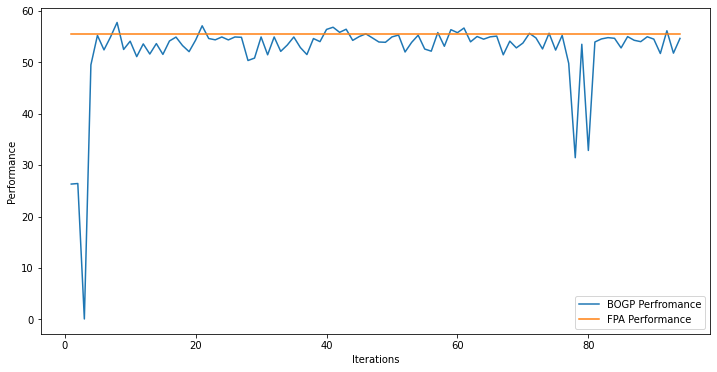

x_next is [ 19.96589653  19.56519056 -30.42542958  19.97114743  19.87380851
  19.65923503  19.67242099 -29.61501317  19.62141719  11.85311966
 -30.64777679  19.23510385 -30.43791623 -30.08416597  19.46378977
  19.96897387  19.8139376   19.56713853  19.51640738  19.64286308]
f()=51.693360, actual=52.149
93


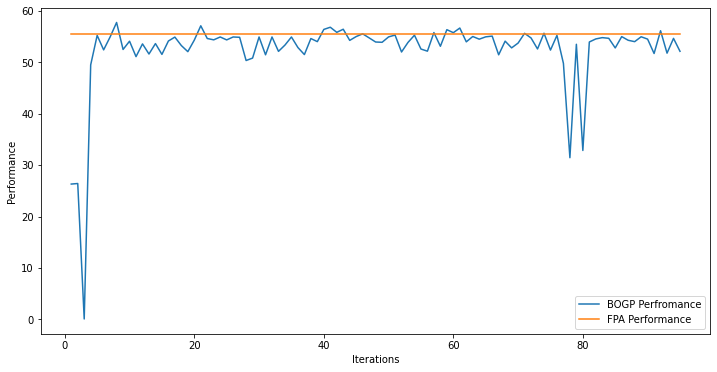

x_next is [ 19.8583888   19.9045061  -30.85786118 -27.10185662  19.76285757
  19.82378803 -29.68594555  19.66701013 -29.79697669   3.09462129
 -30.44009359  19.50529821  19.81401921  19.99337109  19.46775739
  19.47182183  19.58226287  19.87911781  19.57238986  19.96401737]
f()=52.881780, actual=54.313
94


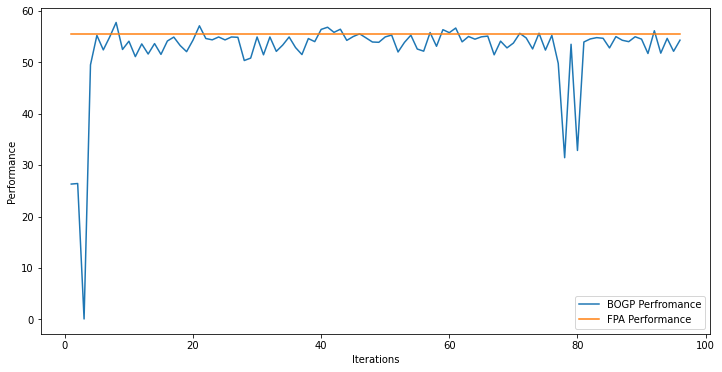

x_next is [ 19.89965192  19.64522136 -30.67770836 -30.96506037  19.47886388
  19.85815554  19.49509132  19.77279448 -30.65712704  -5.42203654
 -30.92700664  19.08997828  18.64960746  19.88896815  19.66627611
  19.25767216  19.82075347  19.90079482  19.61138644  19.67778125]
f()=55.019819, actual=53.750
95


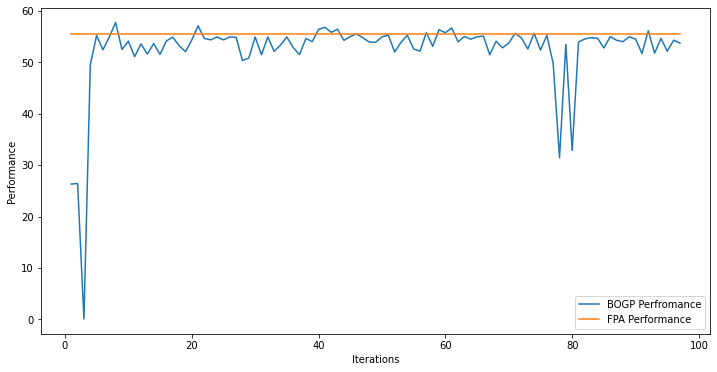

x_next is [ 17.52178047 -22.27472363 -13.92157354 -17.93585639   9.13226552
  18.89706873  17.76289032   9.55941276  12.51502161   3.05834652
 -30.35688835  16.92921652  -0.61877083 -29.030972    17.88727245
  19.75573502  14.4663688  -26.09658051  13.44965768 -30.76930885]
f()=37.012419, actual=39.318
96


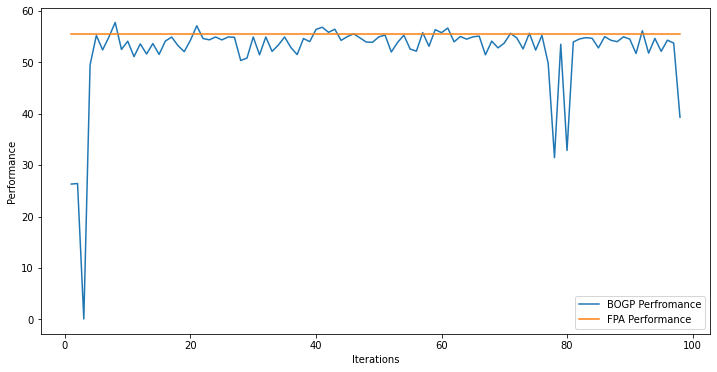

x_next is [ 19.94650291  19.67864492 -30.69838624 -28.44802629  19.74096233
  19.750955   -30.6591748   19.99516353  19.85466416   8.54730119
 -30.55952734  19.862681    19.69017799  19.77599616 -29.86384059
  19.90407603  19.79383712 -30.03511431  19.9827702   19.98370772]
f()=50.103225, actual=51.523
97


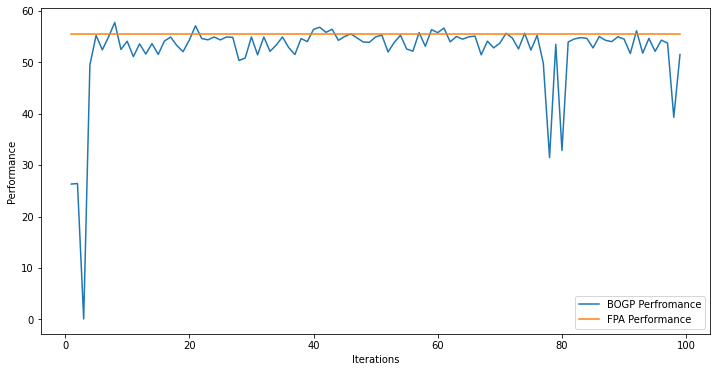

x_next is [ 20.          19.99997737 -30.99998297  19.99999999  20.
  19.99999999  20.          19.99971379  19.99999999 -19.92640504
 -30.99999995  20.          20.          19.99999999 -30.99999996
  20.          19.99967972  20.          20.          20.        ]
f()=56.014278, actual=54.314
98


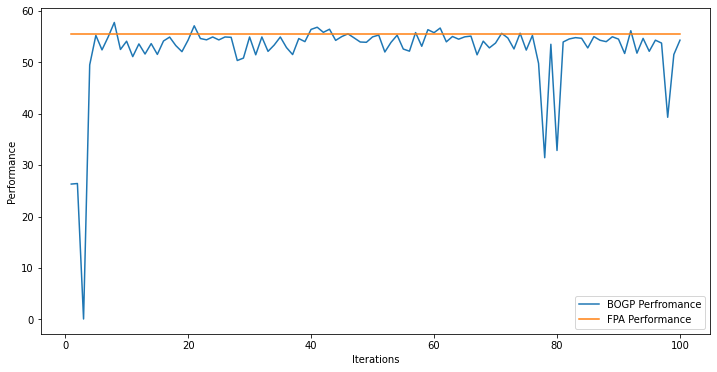

x_next is [ 19.9323143  -29.66092848 -30.40226896  19.83650441  19.86012286
  19.94368246 -30.32626944  19.8287688   19.93278494   3.92368173
 -30.88662233  19.86090876  19.94186976  19.91808544  19.81761752
  19.51658605  19.63499864  19.95768099  19.99481376  19.72234621]
f()=53.710727, actual=54.663
99


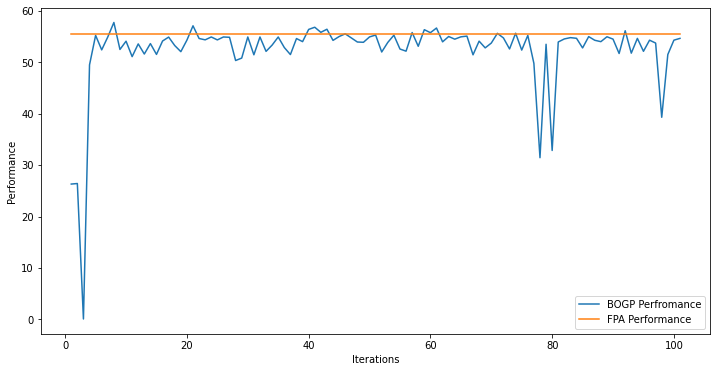

x_next is [ 20.          19.99994002 -30.99977891  19.99999999  19.99992259
  19.99999999  19.99985884  19.99998469  19.99989245  10.68930879
 -30.9996678   19.99999998  19.99999999  19.99980459  19.99997012
  19.99999248  20.          20.          20.          19.99991137]
f()=56.254104, actual=58.223
100


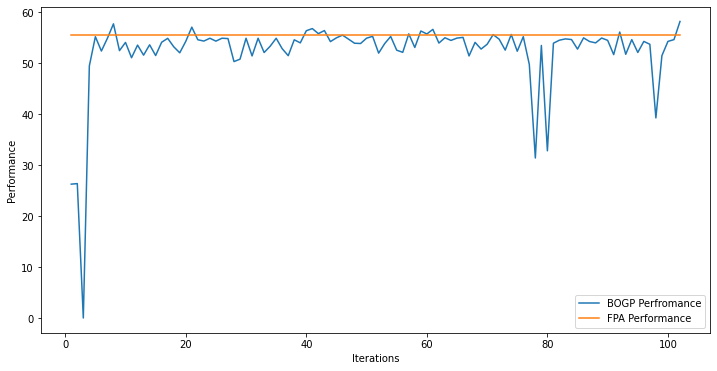

x_next is [ 19.8224336   19.77126173 -30.91449065  19.80803058  19.95073222
  19.9080623  -30.69038326  19.74600707  19.62767161  -5.65017266
 -30.53530483  19.96072974  19.9872191  -30.99670516  19.66441638
  19.5243822   19.92382597  19.71343718  19.99932307  19.75117254]
f()=53.279419, actual=52.458
101


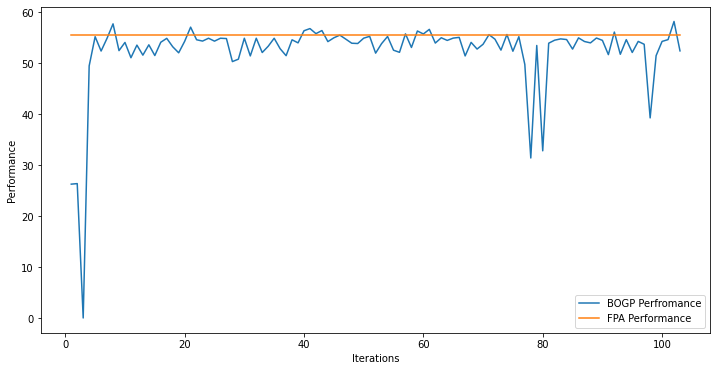

x_next is [ 19.84631042  19.84291584 -30.58819372  19.53768657  19.93027305
  19.71287184  19.48115777  19.88276102  19.97084409  -6.22099325
 -30.74256561 -19.96505265  19.89899575  19.73196637  19.74358774
  19.99167256  19.95863156 -29.95274749  19.62489433  19.98595185]
f()=53.373194, actual=51.498
102


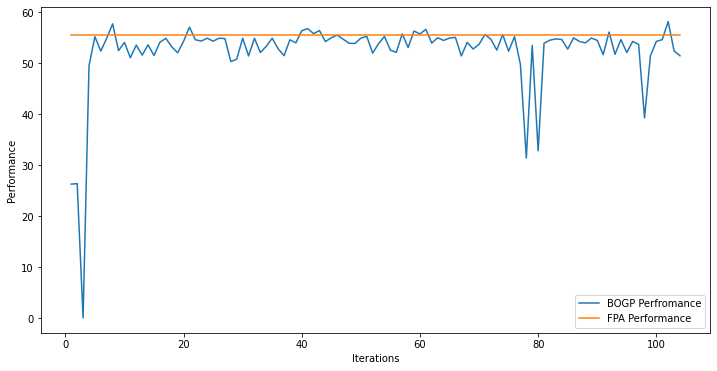

x_next is [ 19.80300434  19.66417418 -30.36275588 -30.53794848  19.95473156
  19.97178837 -30.49748715  19.34416931  19.69830857   6.40000961
  19.94933929  19.75845085  19.89476983  19.99170431 -30.88872174
  19.92303887  19.73108121  19.85637068  19.56601629  19.90625477]
f()=52.872891, actual=54.290
103


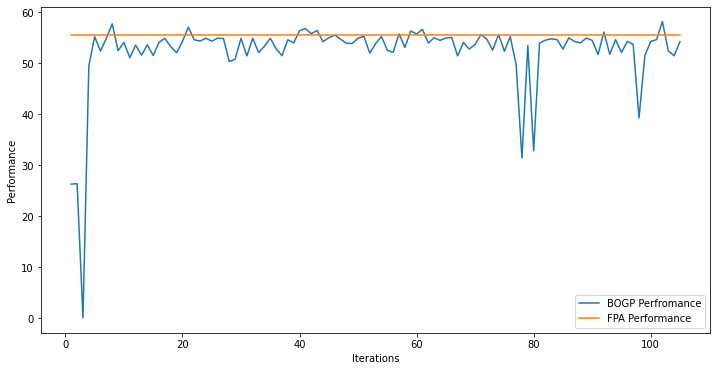

x_next is [ 18.6992991   18.33781724 -29.19018086 -29.53533274  19.17166955
  18.75898913  19.74519896  17.10790091  18.17867823  17.5377447
  19.99263367 -29.73686433  17.45481807 -29.50322358 -28.95307477
  18.23393946  18.86286141  18.44593178  17.69957597  18.5746209 ]
f()=49.923325, actual=51.002
104


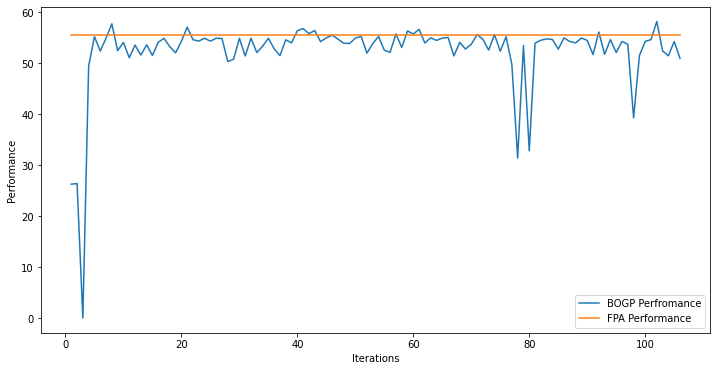

x_next is [ 19.95952952 -23.97096697 -30.93235299  19.9484352   19.98230108
  19.70894322  19.66263284 -30.07409748  19.98190129  -7.06294843
 -30.39496436  19.91155625  19.80482063  19.69996244  19.9983021
  19.86092046  19.87894768  19.94029345  19.8332411   19.96910567]
f()=54.280693, actual=52.681
105


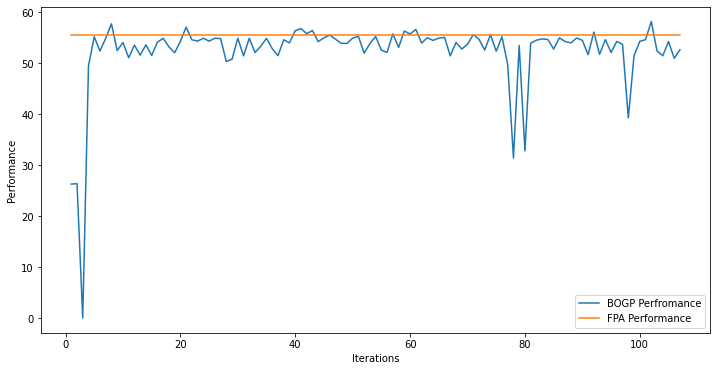

x_next is [ 19.49384371  19.22470926 -24.12352133 -30.95741436  18.90710876
  15.54434887  15.86862852  16.49036591  18.54895673 -30.12934196
 -23.48979339  17.31098242 -17.0331016   14.44796632  17.26728964
 -29.44464807  19.85589449  17.3700066   17.2263586   19.17944978]
f()=46.549048, actual=46.297
106


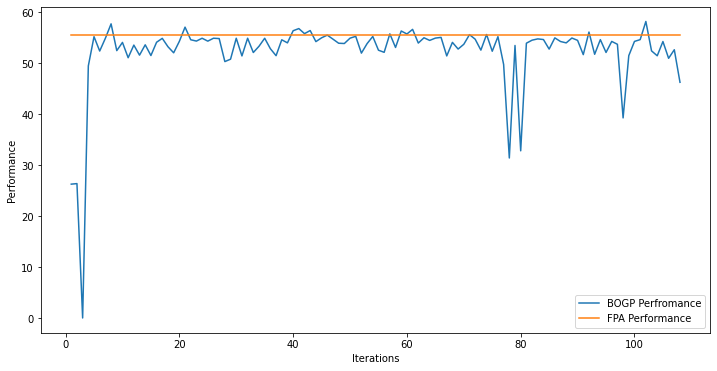

x_next is [ 19.99401799  19.58114715 -30.57475136 -30.84702175  19.83006832
  19.95483128 -29.52547611  19.7155144  -30.29160632  19.33602141
 -30.73654677  19.63215136  19.65075754 -30.6038005  -30.47482872
  19.98351947  19.94842464  19.81731377  19.80449148  19.78927363]
f()=51.702307, actual=50.272
107


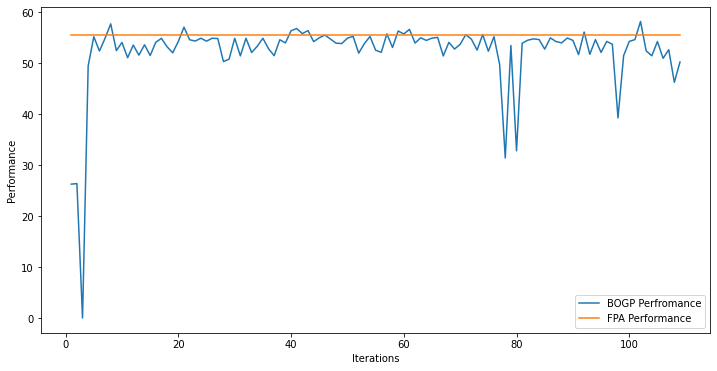

x_next is [ 20.          20.         -30.99998729  20.          20.
  20.          19.99999999  19.99999999  19.99991834  20.
 -30.99993025  19.99999999  20.          20.          20.
  20.          20.          20.          20.          20.        ]
f()=56.712547, actual=55.308
108


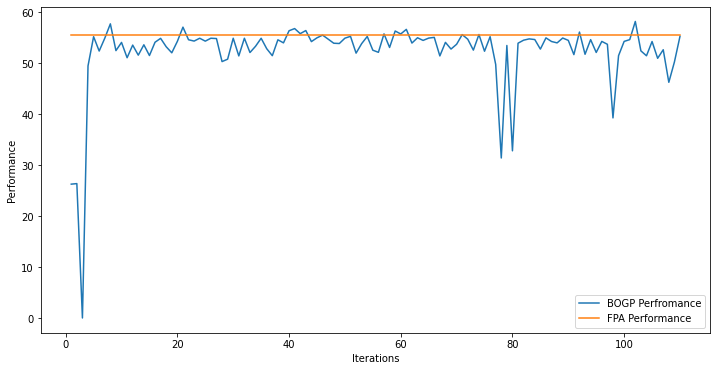

x_next is [ 19.99989905  19.99952756  19.99997129  19.9996067   19.99992673
  19.99996079  19.99993193  19.99982376 -30.9998371   -5.38757737
  19.99991353  19.99983691  19.99974643  19.99977359 -30.99999642
  19.99985655  19.9999173   19.99988962  19.9997795   19.99985775]
f()=55.580268, actual=54.913
109


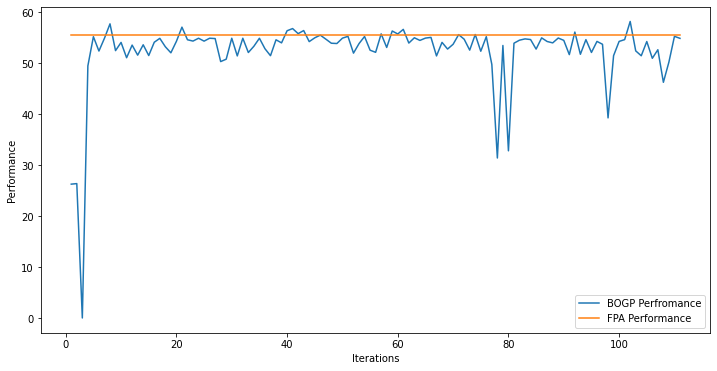

x_next is [ 19.94717236  19.96575001 -30.70129337  19.85645256  19.89518132
  19.80873861 -30.80294927  19.95526485 -30.82733285  -1.57172848
 -30.7338837   19.15209256  19.87031386  19.57022684  19.86999748
  19.82092304  19.9352237   19.83239317  19.68944567  19.6684212 ]
f()=55.099741, actual=54.555
110


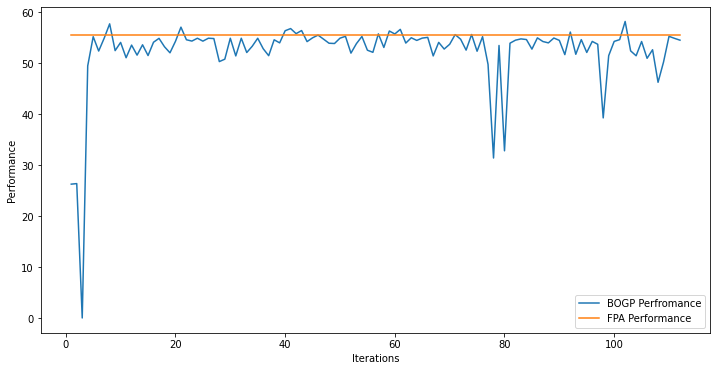

x_next is [ 19.77662127  19.98499829 -30.41998749 -28.17944091  19.93231252
  19.67322753  19.93150869  19.2873151   19.69067552  -9.82004042
  18.89187828  19.97139463  19.39757304  19.7701847   19.62719649
  19.78260992  19.86931561  19.86654511  19.99539412  19.96757694]
f()=54.871259, actual=53.829
111


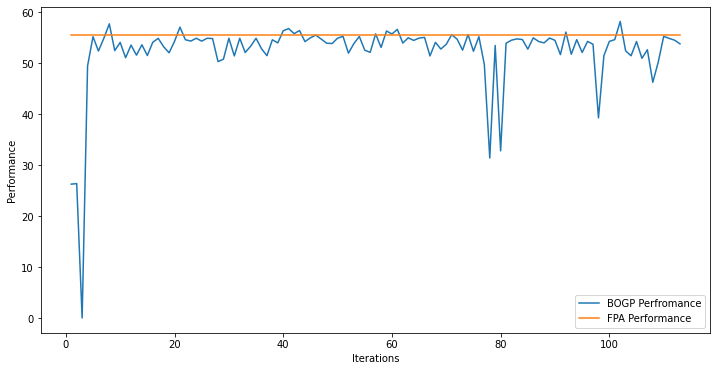

x_next is [ 19.99492116  19.87021015 -30.65878568  19.49088386  19.95564078
  19.9646818   19.95892656 -30.95544027  19.87981846  -2.62867274
 -30.98081546 -30.05272478  19.96750593 -30.42214333  19.70331598
  19.68954513  19.99524314  19.97875915  19.73412402  19.96608572]
f()=54.011958, actual=52.142
112


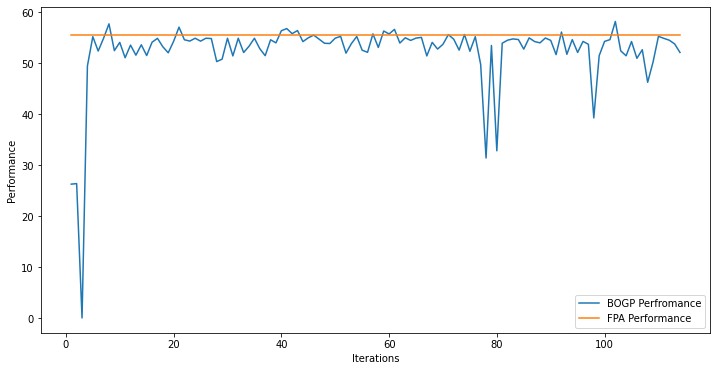

x_next is [ 19.86888626 -30.57496999  19.6853817   19.29168247  19.88484134
  19.91637966  19.34870929  19.89544169 -30.85913614  10.52807648
 -30.85377837  19.95539563  19.96795066  19.7509316  -29.28330725
  19.71252451  19.92468701  19.89477968  19.9962015   19.9988582 ]
f()=52.284482, actual=56.261
113


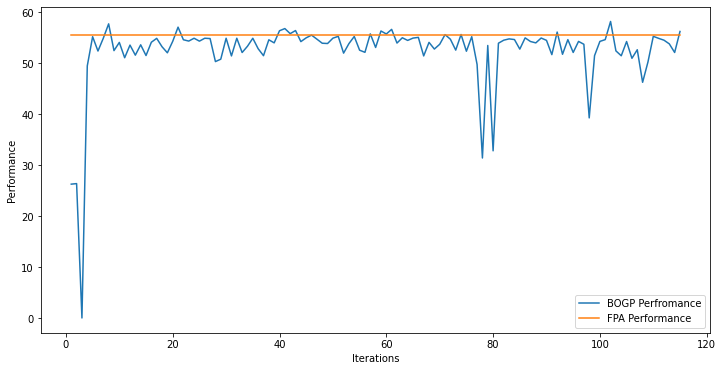

x_next is [ 19.91353357 -30.95657072  19.72953277 -30.98420274  19.8942487
  19.97208401 -30.1991066   19.90102769  19.585658    17.33853826
 -30.78672071  19.77306065  19.96513654  19.99016849 -30.98258628
  19.76920749  19.99088003  19.9280482   19.84317532  19.97987814]
f()=50.917926, actual=52.517
114


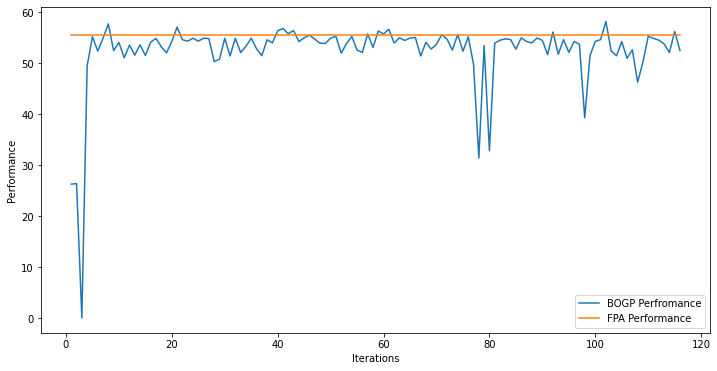

x_next is [-30.22040497 -21.73663927 -10.68679624  11.43338831 -26.26856689
 -16.05740215 -28.85409928   2.38588953 -13.23550925 -16.71547587
  12.91153458 -27.44275118 -14.41493062  -6.46151455 -16.1748067
 -27.74897343  -0.11002387 -10.8730614  -26.89711848  -2.63332578]
f()=52.419605, actual=10.130
115


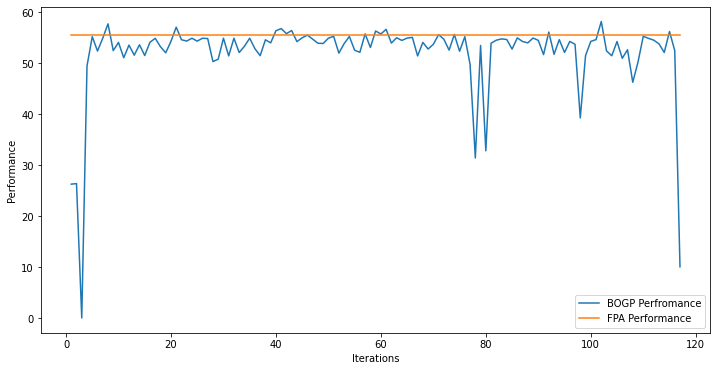

x_next is [-26.46314734 -21.09463303  11.19618006   6.50846198 -30.46325351
  -8.74355603  -6.04586269  -3.76428473   7.33841173  16.85139401
 -19.48566843 -25.21050065 -22.23416418  -5.13359064 -11.931567
  -7.23487992  10.01075405 -24.85241087 -12.41161278 -25.96497668]
f()=52.055662, actual=18.619
116


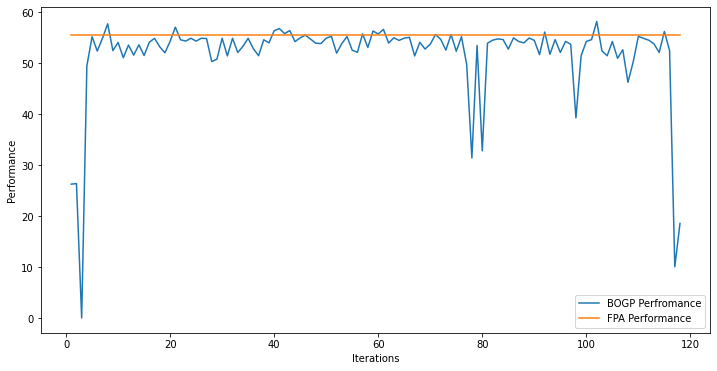

x_next is [ 19.9731954   19.97610035  19.7362527   19.95545399  19.82509624
  19.74031237  19.6467128   19.84003493 -30.74254364   7.5089554
 -30.7645478   19.59222582  19.59146222  19.85484764 -30.97391592
  19.81230174 -30.86357143  19.92232545  19.99034116  19.67647801]
f()=51.434814, actual=54.494
117


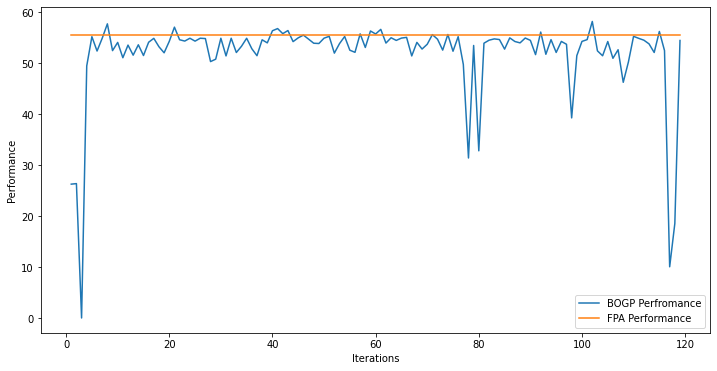

x_next is [ 11.70089633  11.78266252  19.31162251 -12.0880936    6.26986012
 -28.85218524 -10.72285019 -19.3105971    8.5727911  -23.23413832
 -14.9161807   16.62268426 -10.51003347 -28.19882863  -7.52743691
  14.3767812   11.6383121  -18.00047094  12.12574842   0.60590657]
f()=51.793757, actual=28.432
118


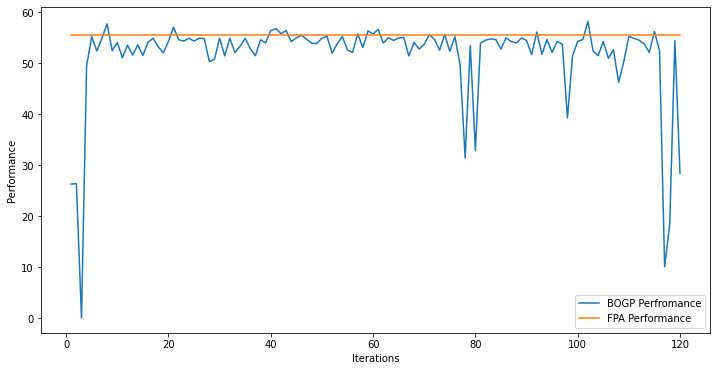

x_next is [ 19.926076   -30.87463576  19.27869371  19.04760903  19.67592009
  19.43412531  19.76517406  19.84849234 -30.09843081   8.7503652
 -30.99608886  19.03043608  19.96913656  19.07730476  19.84389548
  19.84970412  19.69665007  19.88747498  19.79338511  19.94642923]
f()=54.758797, actual=56.849
119


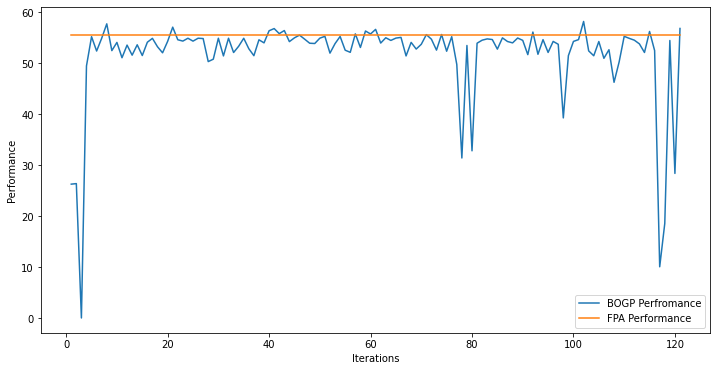

x_next is [ 19.93308647 -30.93969284  19.86904988  19.67304478  19.91658762
  19.81447436  19.9985219   19.82829472 -30.97627078  13.52199305
 -30.77623208  19.89235986  19.82028987 -30.68791995  19.90002692
  19.98645197  19.81641697  19.95930227  19.87785289  19.98613733]
f()=53.808456, actual=55.330
120


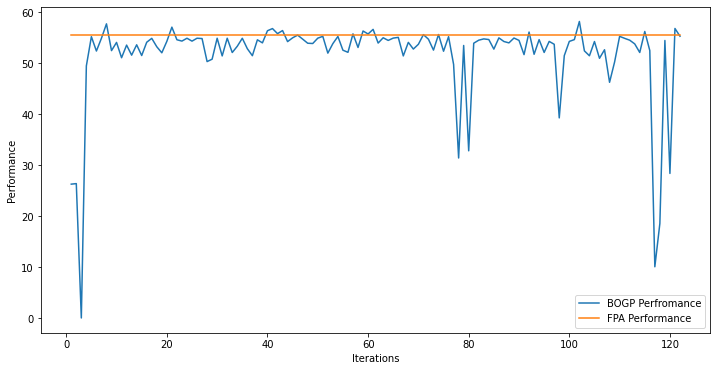

x_next is [ 20.          19.99999999 -30.99958426  20.          20.
  20.          19.99999999  19.99989378  19.99999998  12.25846448
 -30.99991514  19.99999996  19.99999996  19.99999999  19.99999999
  20.          20.          20.          20.          20.        ]
f()=56.439604, actual=58.129
121


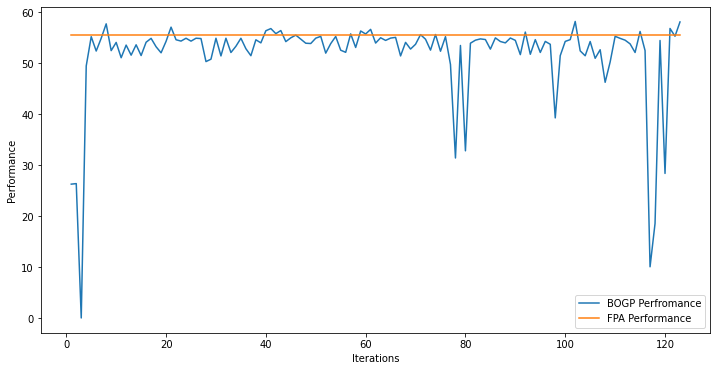

x_next is [ 19.89062256  19.99062442 -29.34450816 -30.23925255  19.59669395
  19.94447654 -29.66820766  19.97836881  19.2394767    6.39679485
 -30.69793617  -8.31055526  19.57262811  19.93964253 -30.44227656
  19.45703394  19.89397749  19.87880366  19.67062648  19.67195073]
f()=54.321096, actual=52.739
122


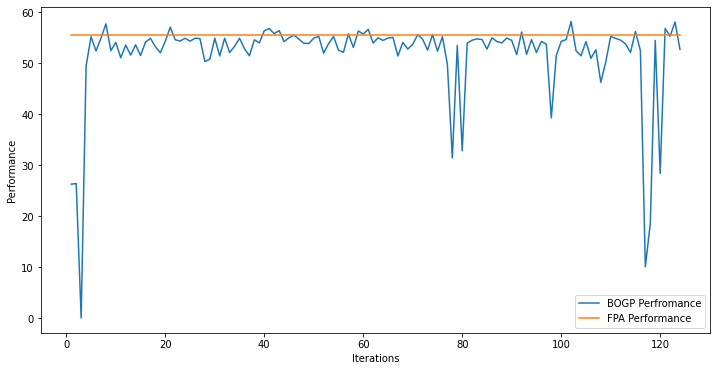

x_next is [ 20.         -30.99998815  20.          20.          20.
  20.          20.          19.99999999 -30.99999995  19.99982762
 -30.99999997  20.          20.          20.          20.
  20.          20.          20.          20.          20.        ]
f()=56.995305, actual=54.590
123


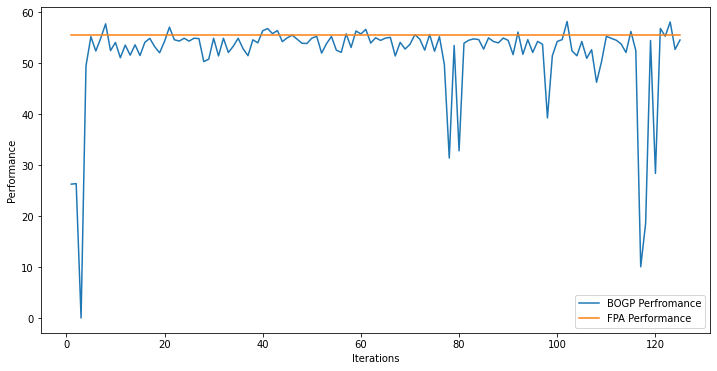

x_next is [-30.42775125 -14.70219999 -25.87132346  -5.69795807   2.70800457
   2.17923013   5.76428082   4.29266353   5.60185695 -14.68563018
 -14.12510027  11.56016683 -25.2870972    1.95341253  -4.57141964
   1.17628612  11.94946354  13.70366476 -21.10045737 -20.23948528]
f()=25.298286, actual=24.764
124


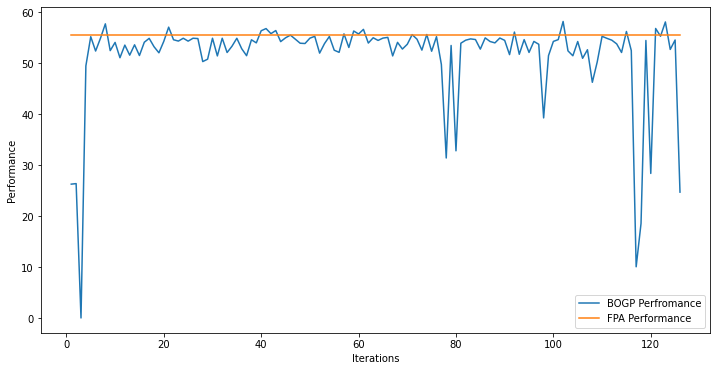

x_next is [ 19.20580296 -30.15782005  19.83348182  19.25936655  19.88319169
  19.37312772  19.94154077  19.54799479  19.05045948  11.95016344
 -29.31183451 -24.44500536  19.96555117 -30.66428822 -29.48267734
  18.88302024  19.52517568  19.48421206  19.75938985  19.86162077]
f()=51.706078, actual=53.901
125


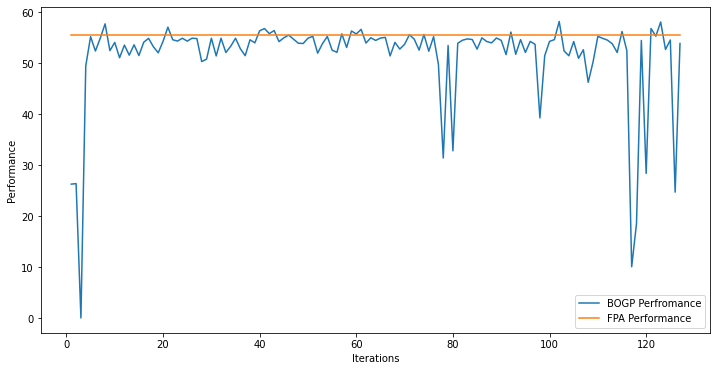

x_next is [ 19.96460377  19.21611047  19.7398907  -28.56277493  19.85500342
  19.94021443 -30.47990843  19.83183913  19.77561399   1.0634189
 -30.92710788  19.55722556  19.78840549  19.76426918  19.38092764
  19.61295561  19.50877732  19.63119773  19.90927903  19.73331112]
f()=52.457745, actual=54.276
126


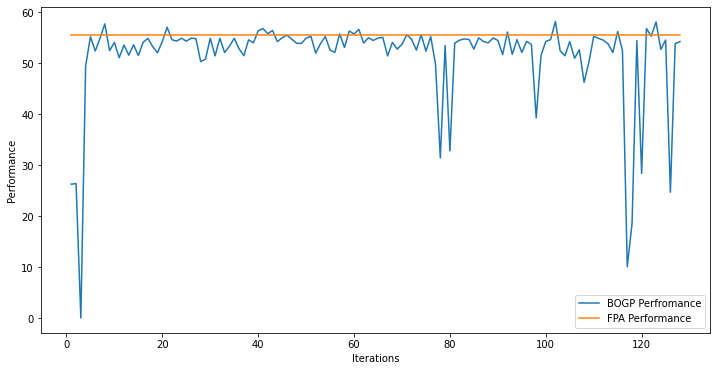

x_next is [ 19.91702997 -30.66192381  19.50257847  19.65880449  19.74571
  19.94628874  19.4849606   19.88625244  19.80467437 -15.9866036
 -30.9527385   19.21399569  19.48656808  19.76998156  19.93747254
  19.88416465  19.85032992  19.83981115  19.89508601  19.9409674 ]
f()=56.155950, actual=53.671
127


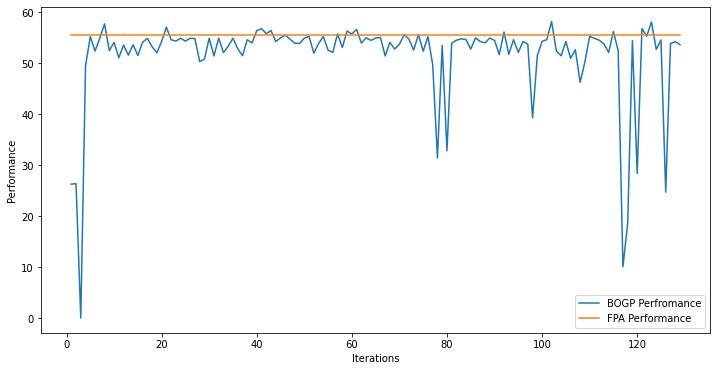

x_next is [ 13.1171124   18.61523758   9.94400655  18.46237738   8.92834464
 -26.8228293  -24.46732763   1.32065504   1.66535774  -5.34564344
  -4.92160144  11.40141058  -5.40184585  13.70190968  10.46696754
 -28.47517054 -26.24952294  11.34748734   3.03487862   1.03540586]
f()=51.597171, actual=30.380
128


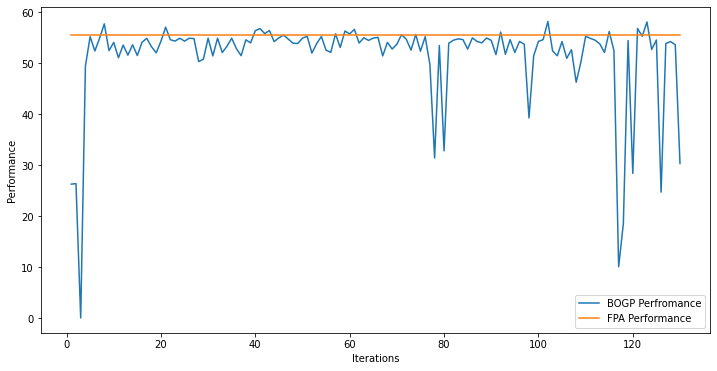

x_next is [ 19.99999999  19.99999999  20.          20.          20.
  19.99999999  19.99999999  19.99999999 -30.99993764  19.99995623
 -30.99980122  19.99999998  19.99999999  19.99999999  19.99999698
  19.99974941  19.99999998  20.          20.          19.99999999]
f()=56.522414, actual=55.190
129


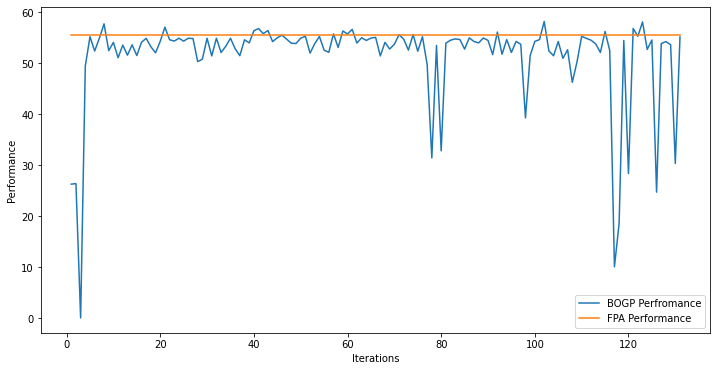

x_next is [ 19.99999999  19.99981656  19.9996688   20.          19.99999999
  20.          20.          20.         -30.99999741  19.99999997
 -30.99999992  19.99999999  20.          20.         -30.99995105
  19.99999999  19.99999999  20.          20.          20.        ]
f()=56.235468, actual=54.405
130


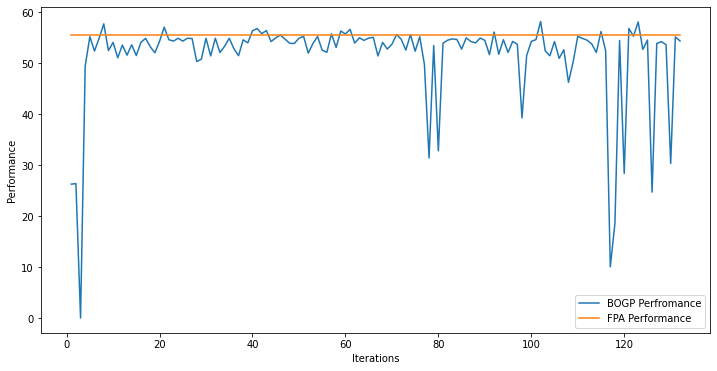

x_next is [ 19.51856035 -26.98894931  19.99088197  19.65548992  19.87895423
  19.84562866  19.67600814  19.89895044 -30.78946902  -8.0590762
 -30.80359301   3.03341636  19.9759493   19.66522646  -3.03900151
  19.8095877   19.3143514   19.87438474  19.86075788  19.93576045]
f()=57.443399, actual=52.203
131


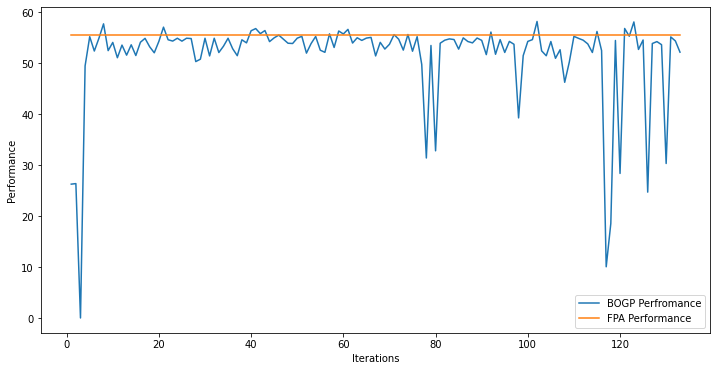

x_next is [ 19.89743789 -30.93368346  11.43007954 -27.96505907  19.95913675
  19.99159821  19.71121203  19.81244113  19.289544    16.44918113
 -30.67088453  19.28145804  19.5963558  -30.48372213 -30.20668037
  19.90914981  19.95039328  19.56112055  19.95062691  19.99380544]
f()=53.253389, actual=52.277
132


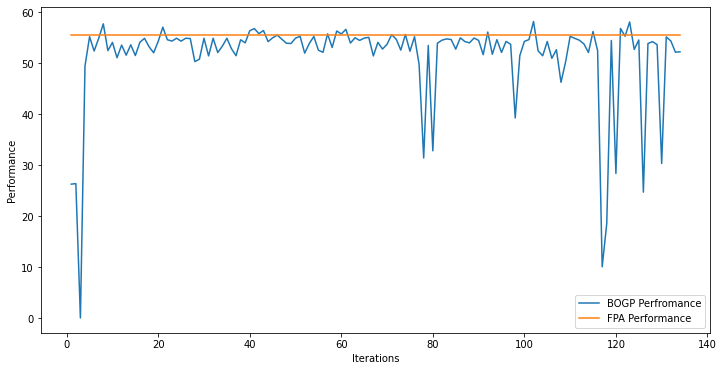

x_next is [ 19.63922657  19.11609503  17.57518032  19.89311027  19.2686536
  19.16175497  17.59989659  19.42677988  17.74304097  15.00262565
 -30.22096887 -27.3671178  -29.83064977 -29.30834141 -30.0408636
  19.03412093 -28.10823715  19.0075921   19.65354193  19.57276226]
f()=48.580991, actual=47.991
133


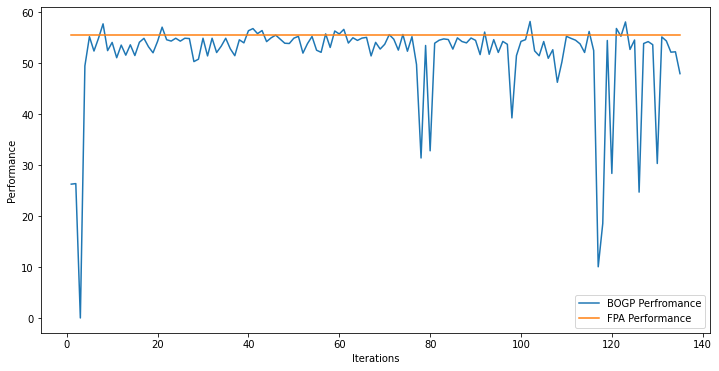

x_next is [ 19.99935115  19.99802876 -30.999939    19.99827942  19.99996753
  19.99981606  19.99975257  19.99750564 -30.99225782  19.99751131
 -30.99892444  19.99994105  19.99811178  19.99889583  19.99570024
  19.99957195  19.99930203  19.99998407  19.99990019  19.99897062]
f()=51.470195, actual=54.915
134


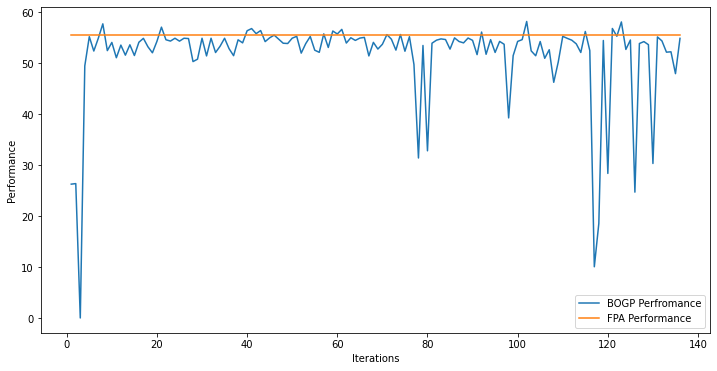

x_next is [ -1.67569111  -0.66755111  -8.95180838 -24.66049828 -21.10032588
   5.91749528 -26.39952151  15.98134552 -30.63638631 -28.12059147
  -3.12377537 -27.69833801 -13.1646171    8.29280424 -16.70787249
  -0.52073829 -26.66942458   4.96986128 -18.73751429  13.59261351]
f()=51.495596, actual=19.355
135


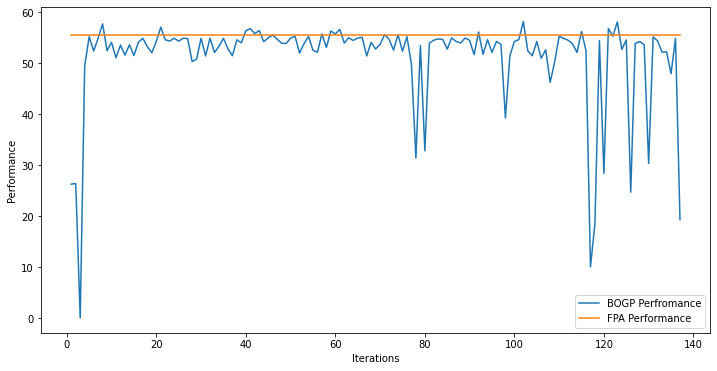

x_next is [ 12.74136884  -9.18104428  -5.68777991 -20.44228799  16.61321923
   1.34597884   2.39153795  10.40036022  12.69296361 -24.96233478
 -11.71397057  10.63439737 -14.15947844 -14.57231683  -2.11173853
 -17.75045604   5.61044311  18.19947122  19.56817764  17.51686488]
f()=51.259950, actual=32.820
136


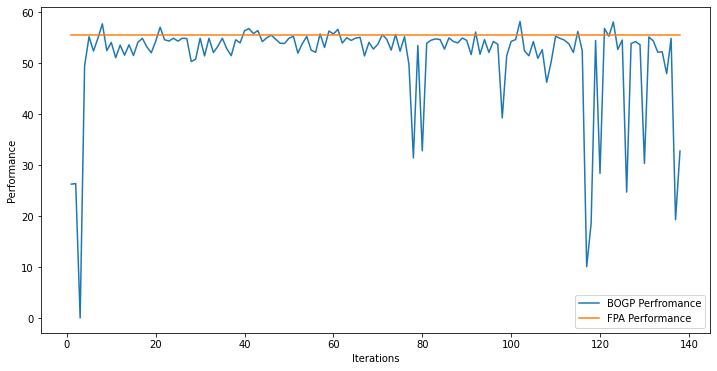

x_next is [-21.49153614 -16.14442718 -18.33811646  -8.57219392 -28.00276114
 -17.88380413 -10.9507095  -21.10106895   0.94010091   8.51434204
   7.02324558 -16.70198341  13.07625396  -8.99759391   6.21396491
 -25.38926522 -28.96817263 -14.33101938  15.81030922 -24.09486298]
f()=51.126037, actual=17.999
137


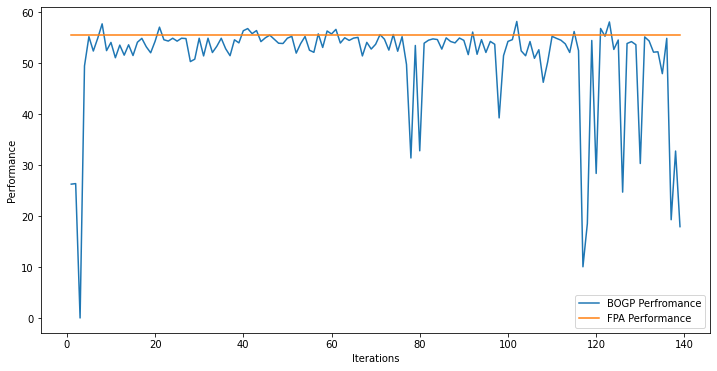

x_next is [ 19.90620246 -30.73902376 -12.44107713  19.99156931  19.69116456
  19.99699027 -26.7433029   19.85399124 -30.20902458  13.39047439
 -30.35019426  19.80938351  19.51562782  19.69476187 -30.78762323
  19.83975803  19.8601841   19.97434537  19.99344717  19.85577557]
f()=53.637981, actual=54.125
138


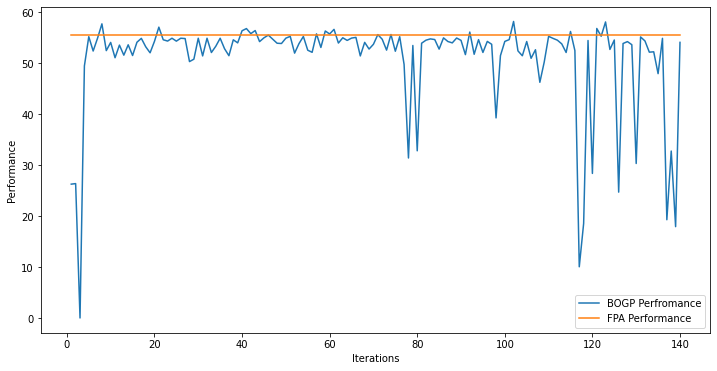

x_next is [ 19.97174371  19.92082186  -9.24538612 -24.45622759  19.91030438
  19.94623095 -28.68485456  19.78322027  19.90885522  19.91096212
 -30.91782174  19.94863876  19.91086433  19.69670831 -30.75176556
  19.83826631 -30.91492714  19.9329594   19.99962832  19.80720702]
f()=50.929850, actual=49.145
139


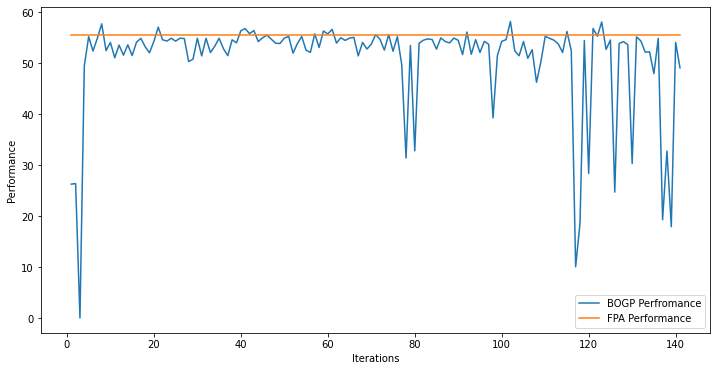

x_next is [ 19.97934656  19.00942713 -30.68211222  18.95409332  19.38461054
  19.8579987   19.97900073 -24.36777704 -30.51599563   2.64802313
 -29.87542147  19.71385812  19.75658872  19.97730271  19.8235936
  19.66762102  19.62175686  19.89152382  19.99975369  19.76748117]
f()=55.671044, actual=55.448
140


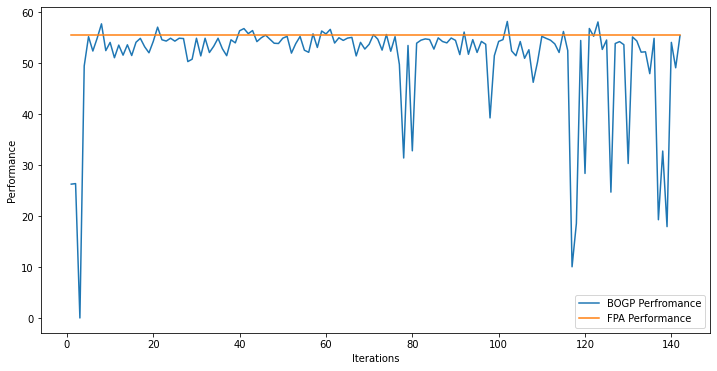

x_next is [ 19.94184451 -25.81928157  19.43774281  -0.55408512  19.801358
  19.88584668 -22.16050453  19.89172982 -30.91789492   3.77237788
 -30.88248355  19.89130983  19.98846265  19.81805842  19.89329616
  19.72462499  19.83366868  19.96461092  19.99756238  19.84149974]
f()=54.619145, actual=54.457
141


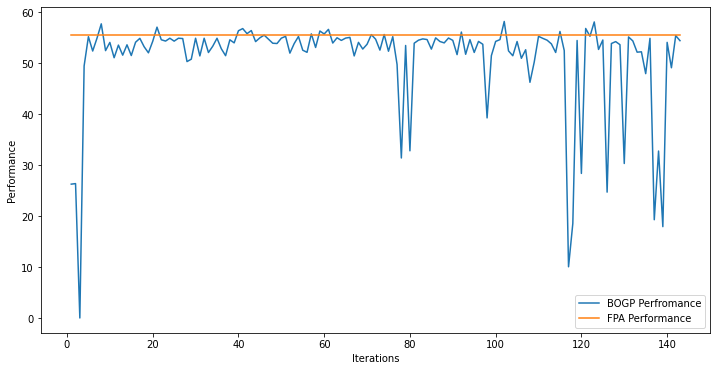

x_next is [ 19.99983082 -30.99997408  19.99830009  19.99899177  19.99985587
 -30.99890471  19.99954949  19.99991061 -30.99979332  11.85328451
 -30.99990772  19.99992266  19.99974479 -30.99889392 -30.99898493
  19.99998099  19.99911025  19.99910761  19.99959516  19.99987261]
f()=50.600763, actual=50.520
142


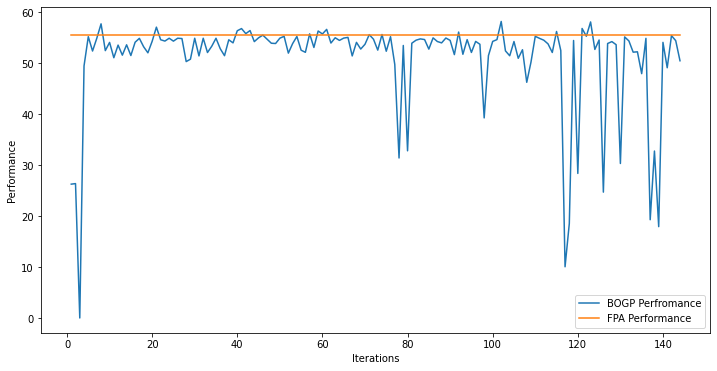

x_next is [ 15.94561888 -27.94777461  17.37113617  16.28684992 -30.55320495
   9.92372155  19.60201251 -29.5009399  -27.09086856   4.71026607
 -17.27428104  18.70108643  13.44873317 -30.64163958  15.29522886
  14.78833481 -29.4521523  -26.7321981  -30.09671953  17.56149557]
f()=30.949126, actual=38.422
143


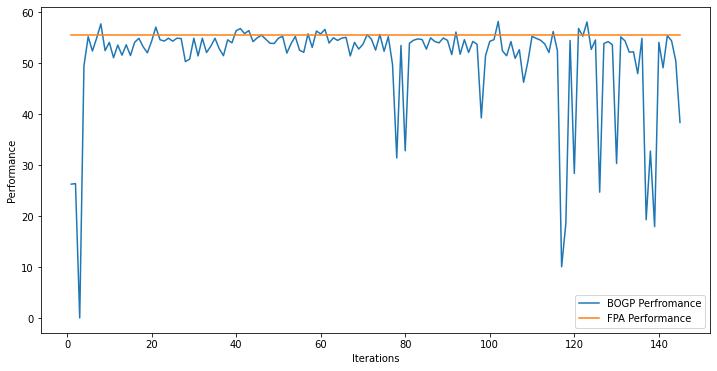

x_next is [ 20.          20.          19.99986475  20.          20.
  20.          20.          19.99999999 -31.          20.
 -31.         -30.99999999  20.          19.99999998  20.
  20.          20.          20.          20.          20.        ]
f()=55.963329, actual=54.398
144


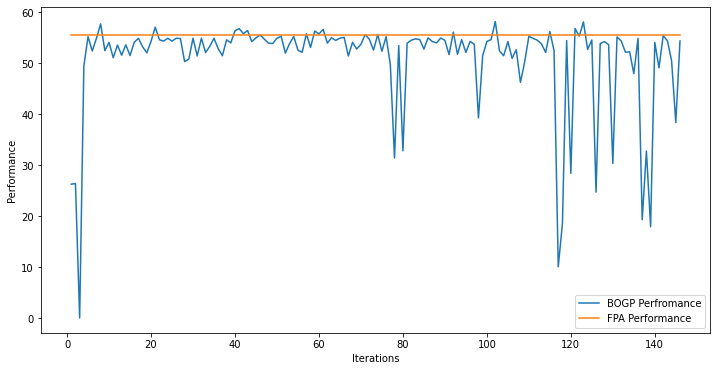

x_next is [-18.69327413 -28.94828168  -6.71434258   5.72016235   9.49898215
  11.57657887 -10.14785546 -11.15543799   9.1863358  -17.16123341
 -11.38069427  -8.67722798   2.21859475 -11.5732016  -29.3621328
  18.16756752 -10.25331441  -8.58892283  15.44998723  14.45694277]
f()=50.889144, actual=28.869
145


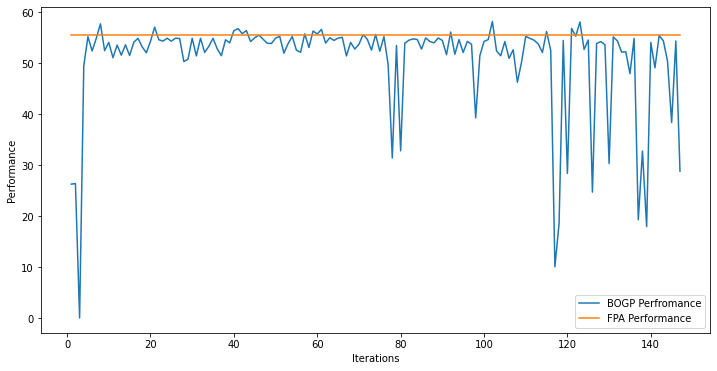

x_next is [-20.28838038  16.9867436  -19.41394863  13.17419437 -16.88783995
  18.6228509    5.34257539   6.08933296 -19.53895801   4.88065492
 -30.89742772 -24.21160735   7.65883201  15.62475695   3.50267672
 -27.28766953  -7.94537629  -6.2737962    5.084697     5.21524721]
f()=50.738950, actual=29.385
146


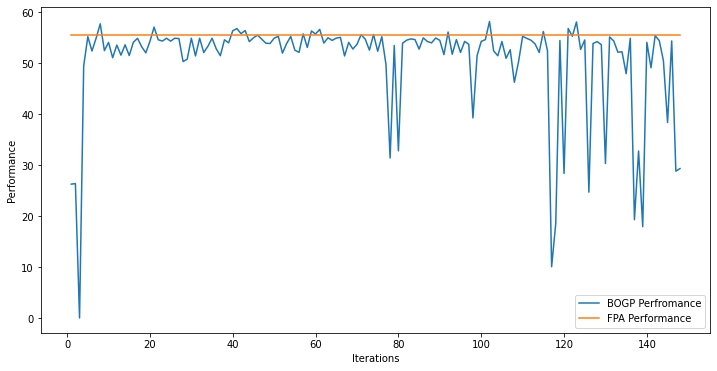

x_next is [ 20.          19.99999998 -30.99994484  19.9999084   20.
  20.          19.99996413  19.99996526  19.99992315   5.40095779
 -30.99996254  19.99999999  20.          19.99999999  19.99989781
  19.99999974  20.          20.          20.          19.99985059]
f()=56.719291, actual=57.718
147


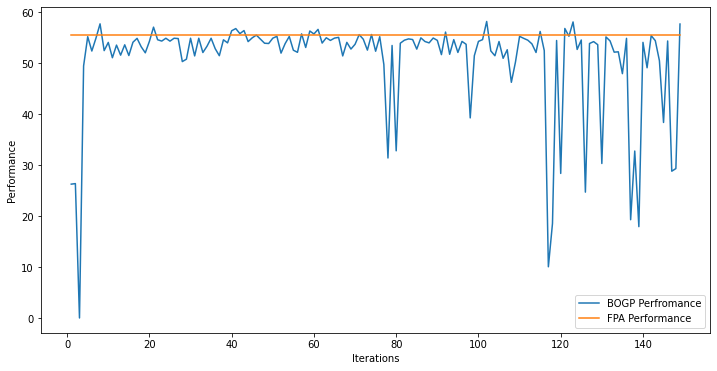

x_next is [ 20.          19.99983814 -30.99996135  20.          20.
  19.99999999  20.          19.99999999  19.99999999   4.46866852
 -30.99992216  19.99976378  20.          20.          20.
  20.          20.          20.          20.          20.        ]
f()=56.867530, actual=57.549
148


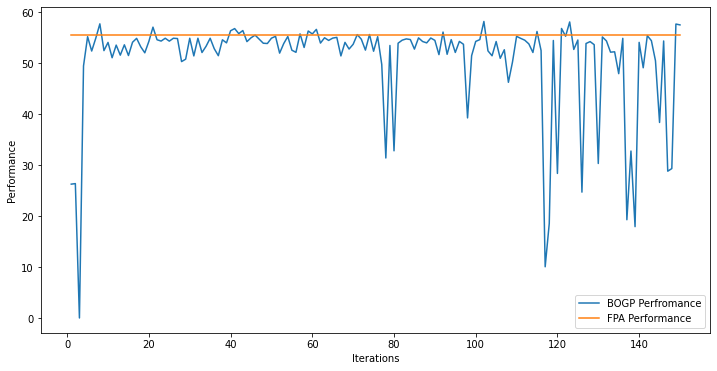

x_next is [ 19.95320572 -30.82441181  19.91508377  19.95697615 -30.38074673
  19.99107056  19.80003928  18.7038374  -30.76628269  15.58934012
 -30.70874985  19.84579632  19.99176012 -30.20405701 -30.53489336
  19.74209213  19.87184328  19.97272705  19.82772708  19.97051924]
f()=50.467824, actual=50.578
149


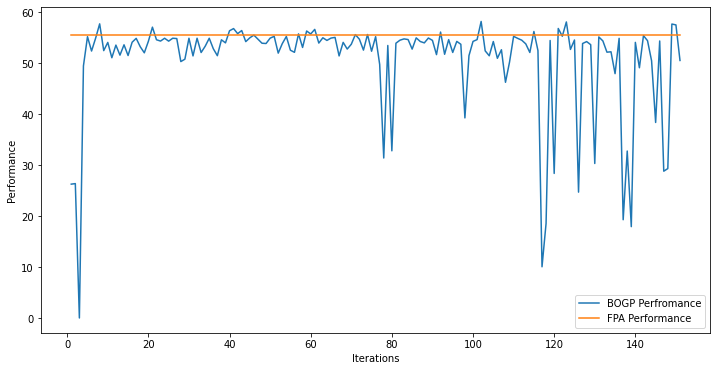

x_next is [ 20.          20.         -30.99999996  20.          20.
  20.          20.          20.          20.           3.91688023
 -30.99997782  20.          20.          20.          20.
  19.99999999  20.          20.          20.          20.        ]
f()=56.958795, actual=57.443
150


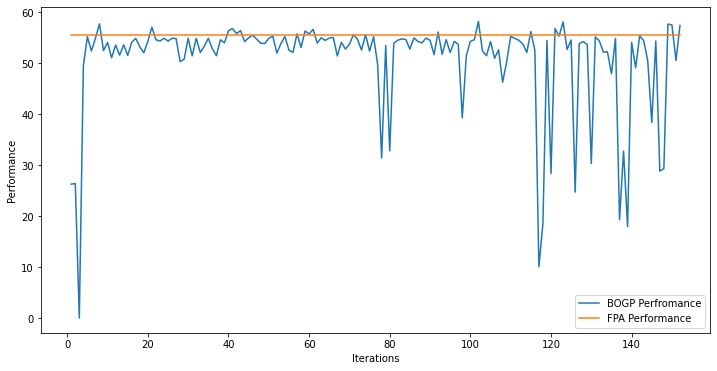

x_next is [ 19.82848925  19.29532549  19.61314735  19.94781038  19.68338533
  19.8555743   19.86518823  19.75541942 -30.96976211   9.1554399
 -30.93156518  19.64817222  19.98741903 -30.91591099  19.80271382
  19.93171499 -30.72231619  19.98499304  19.88023704  19.97650412]
f()=52.564565, actual=53.764
151


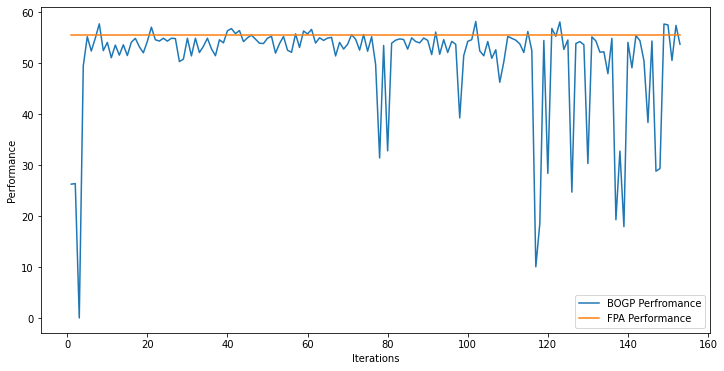

x_next is [ 20.          19.99999999 -30.99998079  20.          20.
  20.          20.          20.          20.           3.49050453
 -30.99945683  20.          20.          20.          20.
  20.          20.          20.          20.          20.        ]
f()=57.020686, actual=57.360
152


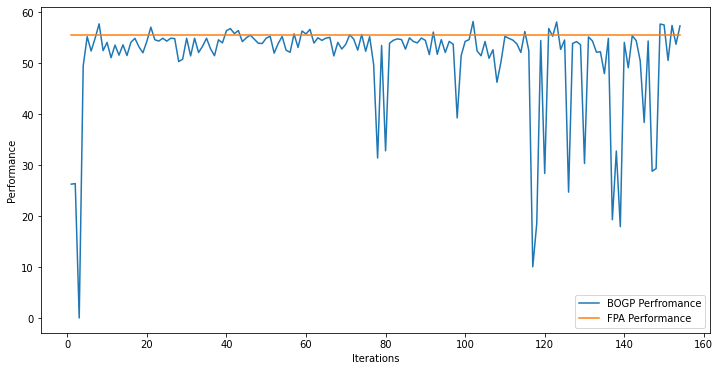

x_next is [  6.11299702 -17.69474324   1.83613818 -19.00583308 -17.83282669
   3.93232661 -22.41698121 -20.95109412  16.11518991 -25.8638977
  17.69711879 -24.18482038  -4.62175052 -15.68858341  14.59593267
  -9.56669758  10.50973     -5.18865984 -26.70717474 -24.30818393]
f()=50.794974, actual=15.876
153


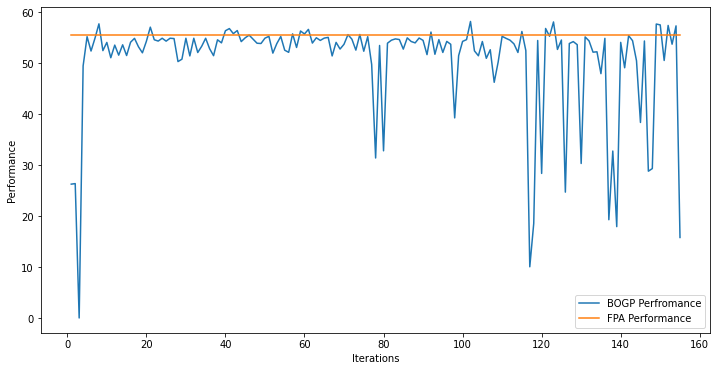

x_next is [ 19.78450582  19.29290566  18.46726909  19.25869712  19.82112073
  19.85448358  19.930206    19.99083967  19.58257892  15.94384104
 -30.74633434 -30.95583465  19.85458255 -30.78470334 -30.96927845
  19.81724444  19.9365399   19.93657972  19.9472056   19.81501041]
f()=54.548572, actual=54.484
154


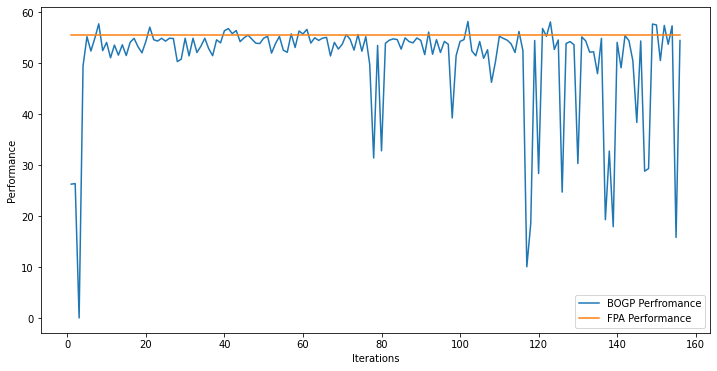

x_next is [ 19.99999998  19.99999999 -30.99987432  19.99999997  19.99999998
  19.99999997  19.99999995  19.99999999  19.9998288   19.99999998
 -30.99983279  19.99999999  19.99999999  20.          19.99999999
  19.99999999  19.99999999  19.99999999  19.99999997  19.99979397]
f()=58.003446, actual=55.308
155


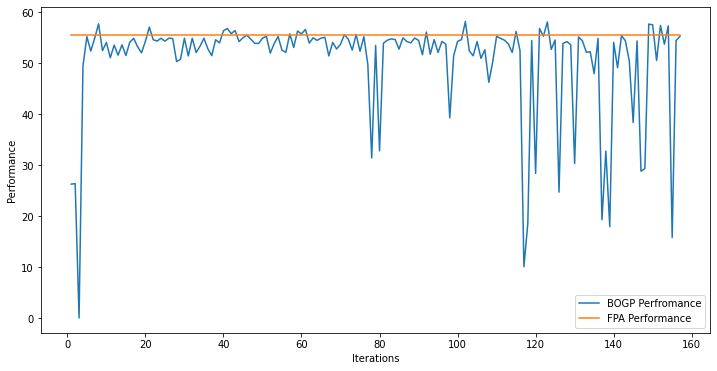

x_next is [ 19.99363055  19.06845242  19.96374505  19.59240854  19.96730735
  19.97865583  19.69660137  19.84082039 -30.83649504   0.29105457
 -30.97773873  19.85902245  19.6935587   19.54722783 -30.75683688
  19.97520299  19.9883787  -30.94294005  19.98591063  19.93599213]
f()=51.367345, actual=52.475
156


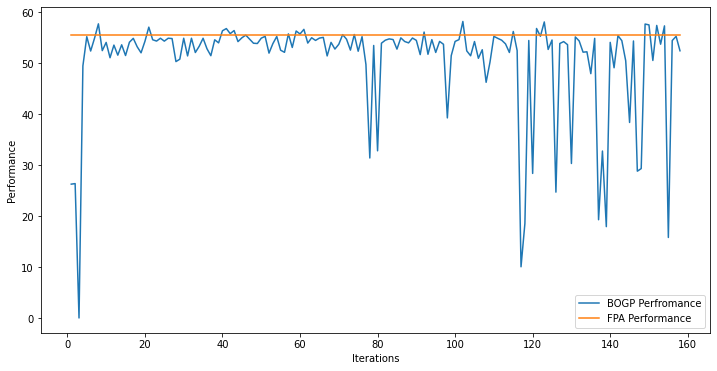

x_next is [-11.16334025  12.22916514  -0.19322074  16.40323065  -0.3811302
 -29.95403856   2.34407972 -19.46500523 -19.93701226 -25.11970402
 -21.68993139 -20.71188793 -15.5920223  -14.57394728   7.479011
   9.13168135 -13.75907074 -21.69339796   3.12841057 -19.97297318]
f()=50.150807, actual=17.778
157


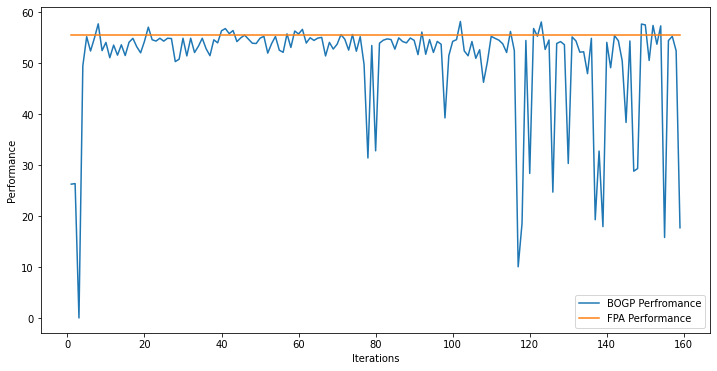

x_next is [ 19.99999996  19.99993779 -30.99999206  19.99990215  19.99999998
  19.99999994  19.99999984  19.99999993  19.99999982  19.9999434
 -30.99945646  19.99999994  19.99994152  19.99999987  19.99999995
  19.99999988  19.99993479  19.99999987  19.99987767  19.99999996]
f()=57.893797, actual=55.308
158


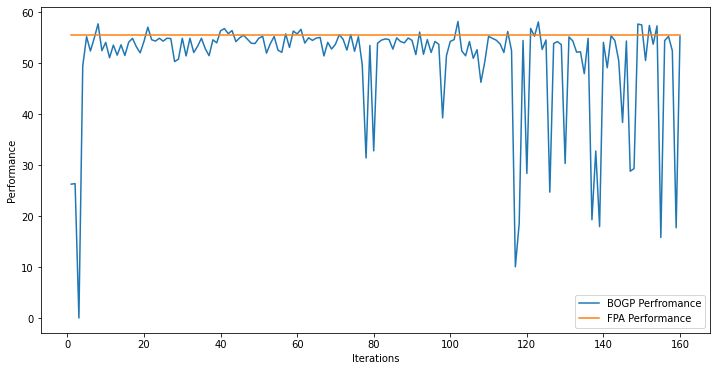

x_next is [ 19.58006727  18.99653121  18.53264324 -16.11343117  19.95650676
  19.9924346   19.26193189  19.85956771 -30.93020432  12.05747189
 -30.63711415  19.52517404  19.51725734 -30.22327396  19.54643351
  19.48873796  19.99033202  19.73975767  19.85803783  19.74727894]
f()=53.949686, actual=54.768
159


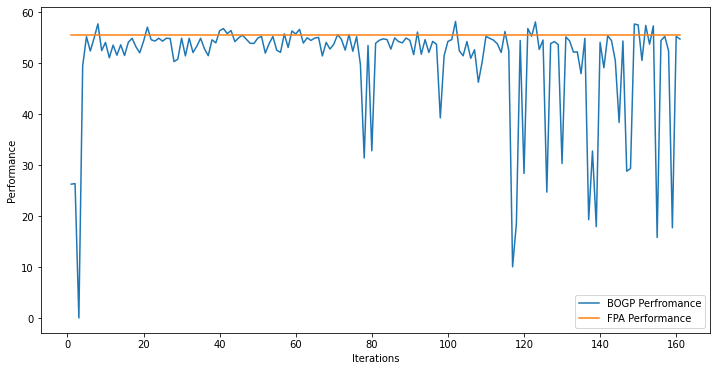

x_next is [ 19.63156061 -15.64062888 -12.35234029  19.51509949  19.89835414
  19.85081665  19.79396178  19.71655402 -30.70916585   1.02262031
 -30.95921433  19.70934113  19.98270642  18.97702064  19.95736099
  19.62217368  19.99421718  19.85983495  19.90860709  19.54278397]
f()=57.095328, actual=54.988
160


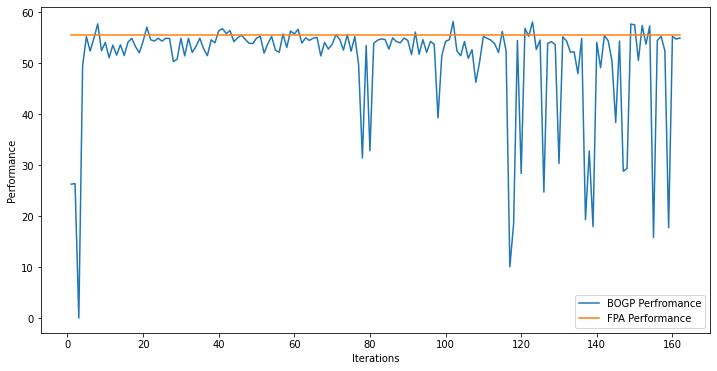

x_next is [ 19.88414814 -30.10402712  19.74053184  19.23194778  19.8990101
  19.97828081  19.9651627   19.98724367 -30.97688158   0.73650905
 -30.93156616  19.80477633  19.8914565   19.14826897  19.90907094
  19.84724062  19.95649473  19.89886159 -30.37977736  19.97288424]
f()=51.858798, actual=52.360
161


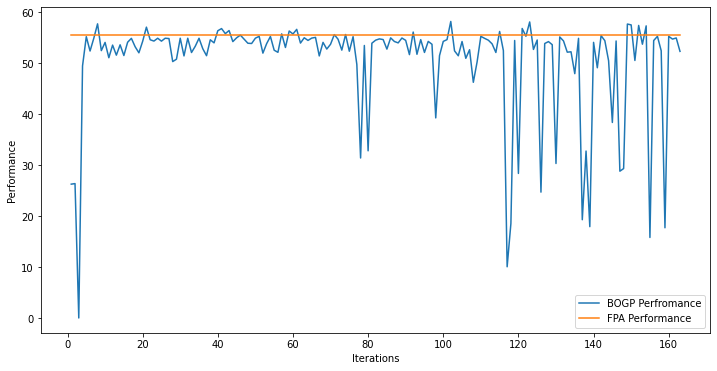

x_next is [ 19.93624264  19.5994497   19.90228925  19.91787296  19.97065869
  19.99329472  19.73463432  19.67058094  19.57383125   0.3817117
 -30.94244877  19.00556944  19.97956908 -30.91483055  19.82222451
  19.87898819  19.88642713  19.99167536  19.73890624  19.78136505]
f()=54.352039, actual=54.918
162


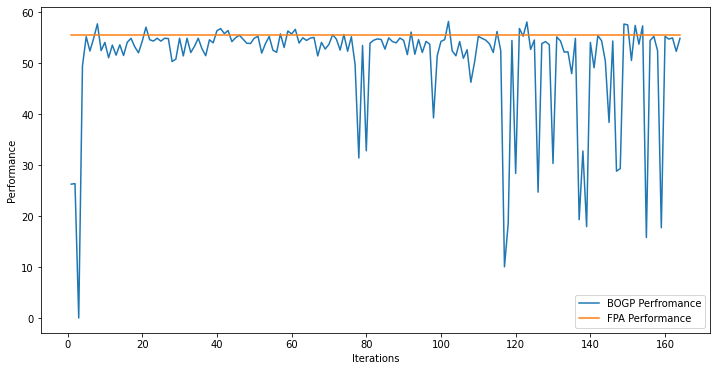

x_next is [ 19.70480699 -29.15510978  19.41325712  19.96669553  19.88915438
  18.06168965  19.42083117 -29.8564359  -30.86817783  15.44371032
 -30.95005124  19.42812613  16.46424644 -26.63609407 -27.29263706
  18.71332211  19.99474755  17.73758409  19.82298551  18.99390297]
f()=52.170376, actual=50.997
163


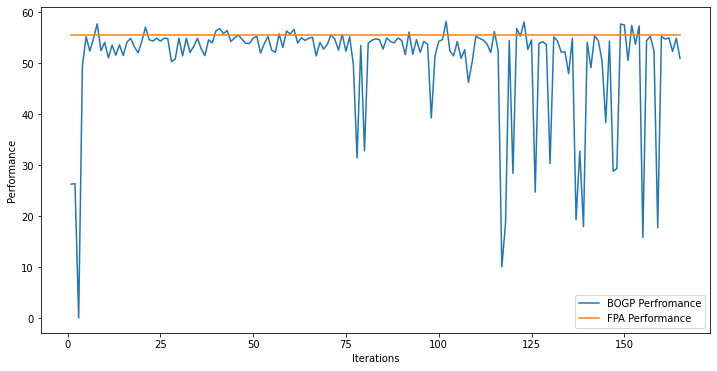

x_next is [ 19.87700526  19.9054027  -30.41137675  19.80889782  19.93308467
  19.89359709  19.96808606 -30.85630038 -30.58893369  17.94145811
 -30.97225979  19.87977492  19.98208591 -30.98084848 -30.99345826
  19.83065291 -30.84650296  19.98341378  19.79152005  19.94960628]
f()=49.879092, actual=50.365
164


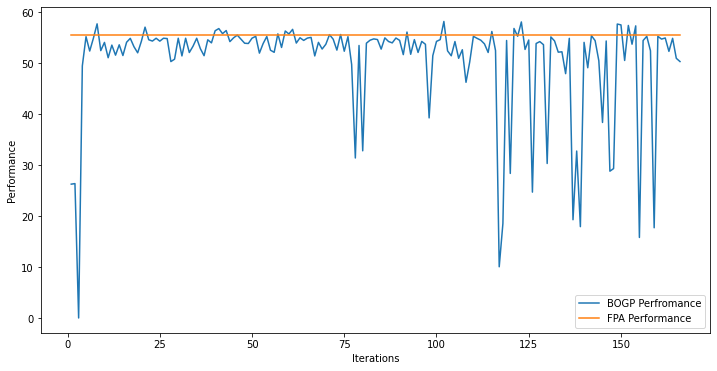

In [ ]:
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

X = 0 * np.ones([1,var], dtype = "float")
y = np.array([[objective_FPA(X[0].reshape((int)(var/number_of_cells), number_of_cells))]])

tr_FPA = objective_FPA(P_max * np.ones([1,var], dtype = "float").reshape((int)(var/number_of_cells), number_of_cells))
y_FPA = np.array([[tr_FPA]])

kernels =  ConstantKernel(constant_value=200, constant_value_bounds = (1e-20, 1e20)) * Matern(length_scale=1, length_scale_bounds=(1e-20,1e20), nu=1.5) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e20)) 
model = GaussianProcessRegressor(kernel = kernels, n_restarts_optimizer=30)

model.fit(X, y)

for i in range(200):
  x_next = opt_acquisition(X, y, model)

  np.save("/content/drive/MyDrive/trainingx_BOGP_EI_P=20.npy",X)
  np.save("/content/drive/MyDrive/trainingy_BOGP_EI_P=20.npy",y)
  np.save("/content/drive/MyDrive/grad_trainingyFPA_BOGP_EI_P=20.npy",y_FPA)
  
  tr = 0
  for l in range(1):
    tr = tr + objective_FPA(x_next.reshape((int)(var/number_of_cells), number_of_cells))
  tr = tr/1.0  
  actual = tr

  tr_FPA = objective_FPA(P_max * np.ones([1,var], dtype = "float").reshape((int)(var/number_of_cells), number_of_cells))
  
  est, _ = surrogate(model, [x_next])
  print("x_next is", x_next)
  print('f()=%3f, actual=%.3f' % (est, actual))
  
  X = vstack((X, [x_next]))
  y = vstack((y, [[actual]]))
  y_FPA = vstack((y_FPA, [[tr_FPA]]))
  
  model.fit(X, y)

  print(i)
  pyplot.figure(figsize = (12, 6))

  pyplot.xlabel("Iterations")
  pyplot.ylabel("Performance")
  pyplot.plot(np.arange(1,X.shape[0]+1),y[:])
  pyplot.plot(np.arange(1,X.shape[0]+1), y_FPA[:])
  pyplot.legend(["BOGP Perfromance","FPA Performance"])
  pyplot.show()






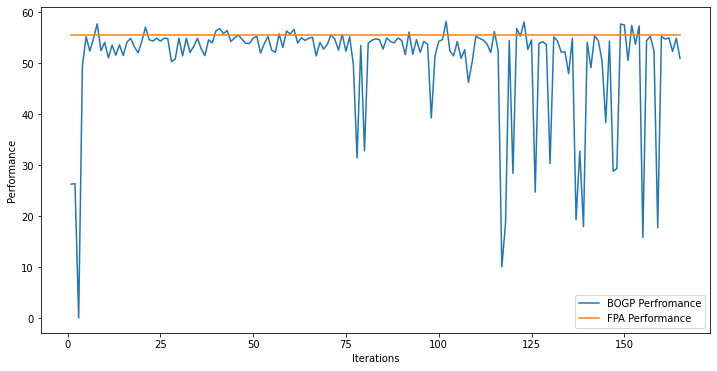

P_max = 20.000, Optimal_SE = 58.223
P_max = 20.000, Optimal_SE_FPA = 55.514


In [15]:
pyplot.figure(figsize = (12, 6))   
pyplot.xlabel("Iterations")
pyplot.ylabel("Performance")
pyplot.plot(np.arange(1,X.shape[0]+1),y[:])
pyplot.plot(np.arange(1,X.shape[0]+1), y_FPA[:])
pyplot.legend(["BOGP Perfromance","FPA Performance"])
pyplot.show() 
ix = 0
ix = argmax(y)
print('P_max = %.3f, Optimal_SE = %.3f' % (P_max, y[ix]))

ix_FPA=0
ix_FPA=argmax(y_FPA)
print('P_max = %.3f, Optimal_SE_FPA = %.3f' % (P_max, y_FPA[ix_FPA]))

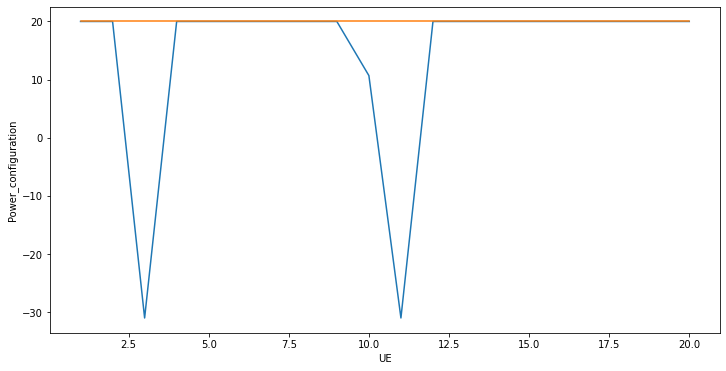

Power_configuration_BOGP is [ 20.          19.99994002 -30.99977891  19.99999999  19.99992259
  19.99999999  19.99985884  19.99998469  19.99989245  10.68930879
 -30.9996678   19.99999998  19.99999999  19.99980459  19.99997012
  19.99999248  20.          20.          20.          19.99991137]


In [16]:
X_FPA = P_max * np.ones([1,var], dtype = "float").reshape((int)(20), 1)
pyplot.figure(figsize = (12, 6)) 
pyplot.xlabel("UE")
pyplot.ylabel("Power_configuration")
pyplot.plot(np.arange(1,21),X[ix][:])
pyplot.plot(np.arange(1,21),X_FPA[:])
pyplot.show()
print("Power_configuration_BOGP is", X[ix])

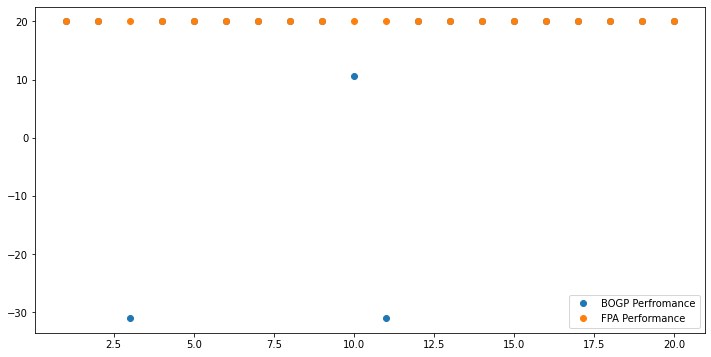

Power_configuration_BOGP is [ 20.          19.99994002 -30.99977891  19.99999999  19.99992259
  19.99999999  19.99985884  19.99998469  19.99989245  10.68930879
 -30.9996678   19.99999998  19.99999999  19.99980459  19.99997012
  19.99999248  20.          20.          20.          19.99991137]


In [17]:
import matplotlib.pyplot as plt
X_FPA=np.linspace(P_max,P_max,20)
plt.figure(figsize = (12, 6)) 
plt.plot(np.arange(1,21),X[ix][:], 'o')
plt.plot(np.arange(1,21),X_FPA[:], 'o')
plt.legend(["BOGP Perfromance","FPA Performance"])
plt.show()
print("Power_configuration_BOGP is", X[ix])